# Set-up

## Required imports

In [1]:
import os
from pathlib import Path
import warnings


import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.colors as mcolors
# import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns

from shapely import wkt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ptitprince as pt


/tmp/ipykernel_22730/393833889.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
from utils.find_repo import find_repo_root

from plots_for_paper.plotting_helper import (create_class_column, set_fonts_for_figure, plot_ps_availability_with_distribution)

In [3]:
%matplotlib inline
plt.ion()  # Turn on interactive mode

In [4]:
warnings.filterwarnings("ignore", message=".*observed=False is deprecated.*")

## Define the paths

In [ ]:
# Find the repo root by looking for a marker file (e.g., .git)
repo_root = find_repo_root()
data_path = os.path.join(repo_root, "data", "plots")


In [6]:
plots_path = os.path.join(data_path, "generated_plots")

if not os.path.exists(plots_path):
    os.makedirs(plots_path)

In [7]:
source_data_folder = os.path.join(data_path, "Source Data")

In [8]:
world_data_boundaries_folder = os.path.join(data_path, "world_boundaries_for_plot")

world_geometries = gpd.read_file(os.path.join(world_data_boundaries_folder,
    "world-administrative-boundaries.shp")
)

## Define plot parameters and colour maps

In [9]:
# Set the desired alpha value
alpha = 0.9  

custom_cmap = ListedColormap(
    [
        to_rgba("#CC3311", alpha),
        to_rgba("#EE7733", alpha),
        to_rgba("#009988", alpha),
        to_rgba("#33BBEE", alpha),
        to_rgba("#0077BB", alpha),
    ]
)
custom_cmap_reversed = ListedColormap(custom_cmap.colors[::-1])

# Create a asymmetrical cmap for heatmap
# Define the list of colors with alpha
colors = [
    to_rgba("#0077BB", alpha),
    to_rgba("#33BBEE", alpha),
    to_rgba("#009988", alpha),
    to_rgba("#EE7733", alpha),
    to_rgba("#CC3311", alpha),
]

# Create a continuous colormap
custom_cmap_asymmetrical = LinearSegmentedColormap.from_list(
    "custom_cmap_continuous", colors
)

# Create a symmetrical cmap for heatmap
# Define the list of colors with alpha
colors = [
    to_rgba("#FFAABB", alpha),
    to_rgba("#EE8866", alpha),
    to_rgba("#44BB99", alpha),
    to_rgba("#99DDFF", alpha),
    to_rgba("#77AADD", alpha),
    to_rgba("#99DDFF", alpha),
    to_rgba("#44BB99", alpha),
    to_rgba("#EE8866", alpha),
    to_rgba("#FFAABB", alpha),
]

# Create a continuous colormap
custom_cmap_symmetric = LinearSegmentedColormap.from_list(
    "custom_cmap_continuous", colors
)

# Define a color palette for the categories
color_palette_SNT = {
    "6 days\n 2 s/c": to_rgba("#0077BB", alpha),
    "12 days\n 2 s/c": to_rgba("#33BBEE", alpha),
    "6 days\n 1 s/c": to_rgba("#009988", alpha),
    "12 days\n 1 s/c": to_rgba("#EE7733", alpha),
    "No SNT \n availability": to_rgba("#CC3311", alpha),
}


# Fig.1 Bridge monitoring capabilities

## Fig.1a PS availability

### Read data

In [10]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig1a_ps_availability.csv"),
)

### Pre-processing

In [11]:
# Define colors and alpha from your original plot
alpha = 0.7  # Adjust this value as needed

# Reverse colors so Very High gets blue (top) and Very Low gets red (bottom)
colors_ordered = [
    to_rgba("#0077BB", alpha),  # Very high (blue)
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#EE7733", alpha),  # Low (orange)
    to_rgba("#CC3311", alpha),  # Very Low (red)
]

# Create custom labels
availability_labels = ["Very high", "High", "Medium", "Low", "Very Low"]

# Create a mapping from original labels to custom labels
label_mapping = {
    "[0, 0.2]": "Very Low",
    "(0.2, 0.4]": "Low", 
    "(0.4, 0.6]": "Medium",
    "(0.6, 0.8]": "High",
    "(0.8, 1.0]": "Very high"
}

# Apply the mapping to create a new column with custom labels
bridges_gdf["PS_availability_labels"] = bridges_gdf["Monitoring_PS_availability_classes"].map(label_mapping)

# Convert to ordered categorical to control the order in the plot
bridges_gdf["PS_availability_labels"] = pd.Categorical(
    bridges_gdf["PS_availability_labels"], 
    categories=availability_labels, 
    ordered=True
)

# Calculate proportions for the bar plot
proportions = bridges_gdf["PS_availability_labels"].value_counts(normalize=True)
# Reorder to match the original order
proportions = proportions.reindex(availability_labels)


### Plot

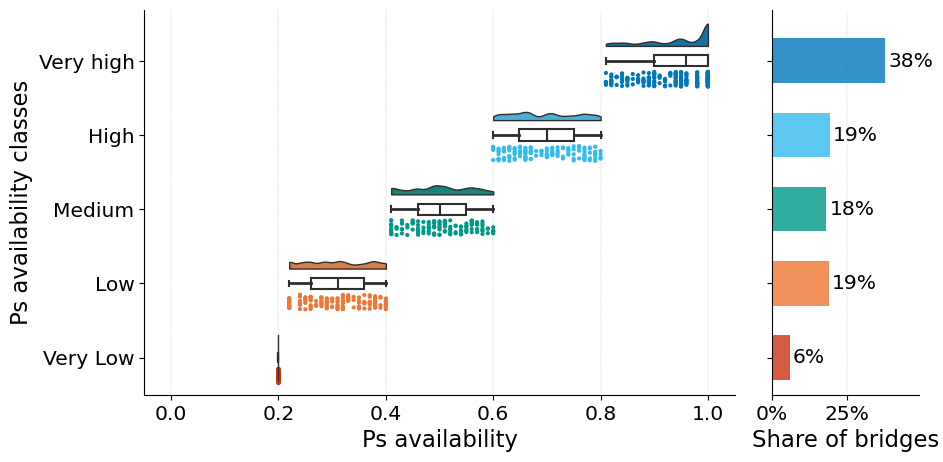

In [12]:
# Set font sizes for the figure
set_fonts_for_figure((10, 5))

# Create two subplots sharing y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True,
                        gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Left subplot: Rainplot
pt.RainCloud(x="PS_availability_labels", y="Monitoring_PS_availability_only",
                data=bridges_gdf, palette=colors_ordered, bw=0.15,
                width_viol=.6, ax=ax1, orient="h", move=0.25)

# Customize left subplot
ax1.set_xlabel("Ps availability")
ax1.set_ylabel("Ps availability classes")
ax1.set_xlim(-.05, 1.05)

# Force the y-tick labels to show properly
ax1.set_yticks(range(len(availability_labels)))
ax1.set_yticklabels(availability_labels)
ax1.tick_params(axis="x")

# Add grid for rainplot
ax1.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax1.set_axisbelow(True)

# Right subplot: Bar chart
bar_height = 0.6  # Make bars thicker since they're now properly aligned
for i, (label, prop) in enumerate(proportions.items()):
        ax2.barh(y=i, width=prop, height=bar_height,
                color=colors_ordered[i], alpha=0.8)
        # Add percentage labels at the end of bars
        ax2.text(prop + 0.01, i, f"{prop:.0%}",
                ha="left", va="center")

# Customize right subplot
ax2.set_xlabel("Share of bridges")
ax2.set_xlim(0, max(proportions) * 1.3)  # Give some space for labels
ax2.tick_params(axis="x")

# Format x-axis as percentages
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))

# Add grid for bar chart
ax2.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax2.set_axisbelow(True)

# Remove y-tick labels from right subplot (shared with left)
# ax2.set_yticklabels([])

# Remove spines
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Save the plot
plt.savefig(
        os.path.join(plots_path, "fig1a_ps_availability.jpg"),
        bbox_inches="tight",
        dpi=600,
)
plt.show()

plt.close()

## Fig.1b SNT availability

### Read data

In [13]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig1b_snt_avail.csv"),
)

### Pre-processing

In [14]:
# Define colors (reordered to match new label order)
color_map = [
    color_palette_SNT["6 days\n 2 s/c"],   # 2 (now first)
    color_palette_SNT["12 days\n 2 s/c"],  # 4
    color_palette_SNT["6 days\n 1 s/c"],   # 1
    color_palette_SNT["12 days\n 1 s/c"],  # 3 (now last)
]

# Define labels in the order you want them displayed (6 days 2s/c on top)
snt_labels = [
    "6 days\n 2 s/c",
    "12 days\n 2 s/c",
    "6 days\n 1 s/c", 
    "12 days\n 1 s/c"
]

snt_labels_new = [
    "6 days\n 2 satellites",
    "12 days\n 2 satellites",
    "6 days\n 1 satellite", 
    "12 days\n 1 satellite"
]

# Calculate proportions for the bar plot using the labeled categories
proportions = bridges_gdf["SNT_availability_2sc_labels"].value_counts(normalize=True)
# Reorder to match the desired order
proportions = proportions.reindex(snt_labels)


# Create categorical labels for SNT availability (matching the order)
snt_category_mapping = {
    3: "12 days\n 1 s/c",
    1: "6 days\n 1 s/c", 
    4: "12 days\n 2 s/c",
    2: "6 days\n 2 s/c"
}

# Apply the mapping to create a new column with custom labels
bridges_gdf["SNT_availability_labels"] = bridges_gdf["SNT_availability_2sc"].map(snt_category_mapping)

# Convert to ordered categorical to control the order in the plot
bridges_gdf["SNT_availability_labels"] = pd.Categorical(
    bridges_gdf["SNT_availability_labels"], 
    categories=snt_labels, 
    ordered=True
)

### Plot

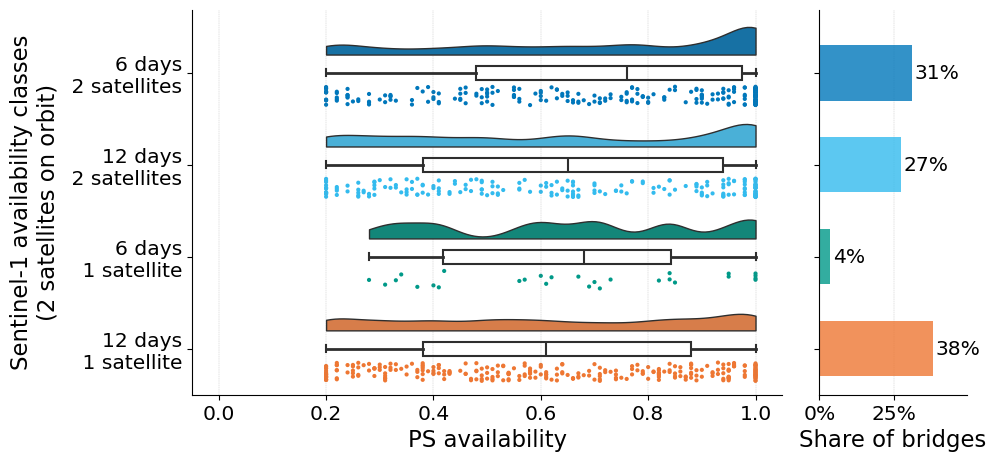

In [15]:
# Set font sizes for the figure
set_fonts_for_figure((10, 5))

# Create two subplots sharing y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True,
                        gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Left subplot: Rainplot with PS availability as continuous variable
pt.RainCloud(x="SNT_availability_labels", y="Monitoring_PS_availability_only",
                data=bridges_gdf, palette=color_map, bw=0.15,
                width_viol=.6, ax=ax1, orient="h", move=0.25)

ax1.set_xlabel("PS availability")
ax1.set_ylabel("Sentinel-1 availability classes\n(2 satellites on orbit)")
ax1.set_xlim(-.05, 1.05)

# Set y-tick labels
ax1.set_yticks(range(len(snt_labels)))
ax1.set_yticklabels(snt_labels_new)
ax1.tick_params(axis="x")

# Add grid for left subplot
ax1.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax1.set_axisbelow(True)

# Right subplot: Horizontal bar chart
bar_height = 0.6
for i, (label, prop) in enumerate(proportions.items()):
    ax2.barh(y=i, width=prop, height=bar_height,
            color=color_map[i], alpha=0.8)
    # Add percentage labels at the end of bars
    ax2.text(prop + 0.01, i, f"{prop:.0%}",
            ha="left", va="center")

# Customize right subplot
ax2.set_xlabel("Share of bridges")
ax2.set_xlim(0, max(proportions) * 1.3)
ax2.tick_params(axis="x")

# Format x-axis as percentages
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))

# Add grid for bar chart
ax2.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax2.set_axisbelow(True)

# Remove spines
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig1b_snt_avail.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()

plt.close()

## Fig.1c Spaceborne monitoring class

### Read data

In [16]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig1c_space_monitoring.csv"),
)

### Pre-processing

In [17]:

# Define alpha from your original plot
alpha = 0.7

# Create the Monitoring_PS_availability_classes column with range labels
bridges_gdf["Spaceborne monitoring class"] = pd.cut(
    bridges_gdf["Monitoring_2sc"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=["[0, 0.2]", "(0.2, 0.4]", "(0.4, 0.6]", "(0.6, 0.8]", "(0.8, 1.0]"],
    right=True,
    include_lowest=True,
)

# Define colors (reordered to match new label order - Very high at top)
colors_ordered = [
    to_rgba("#0077BB", alpha),  # Very high (blue) - now first
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#EE7733", alpha),  # Low (orange)
    to_rgba("#CC3311", alpha),  # No monitoring (red) - now last
]

# Create custom labels (Very high at top, No monitoring at bottom)
monitoring_labels = ["Very high", "High", "Medium", "Low", "No monitoring"]

# Create a mapping from original labels to custom labels
label_mapping = {
    "[0, 0.2]": "No monitoring",
    "(0.2, 0.4]": "Low", 
    "(0.4, 0.6]": "Medium",
    "(0.6, 0.8]": "High",
    "(0.8, 1.0]": "Very high"
}

# Apply the mapping to create a new column with custom labels
bridges_gdf["Spaceborne_monitoring_labels"] = bridges_gdf["Spaceborne monitoring class"].map(label_mapping)

# Convert to ordered categorical to control the order in the plot
bridges_gdf["Spaceborne_monitoring_labels"] = pd.Categorical(
    bridges_gdf["Spaceborne_monitoring_labels"], 
    categories=monitoring_labels, 
    ordered=True
)

# Calculate proportions for the bar plot
proportions = bridges_gdf["Spaceborne_monitoring_labels"].value_counts(normalize=True)
# Reorder to match the original order
proportions = proportions.reindex(monitoring_labels)


### Plot

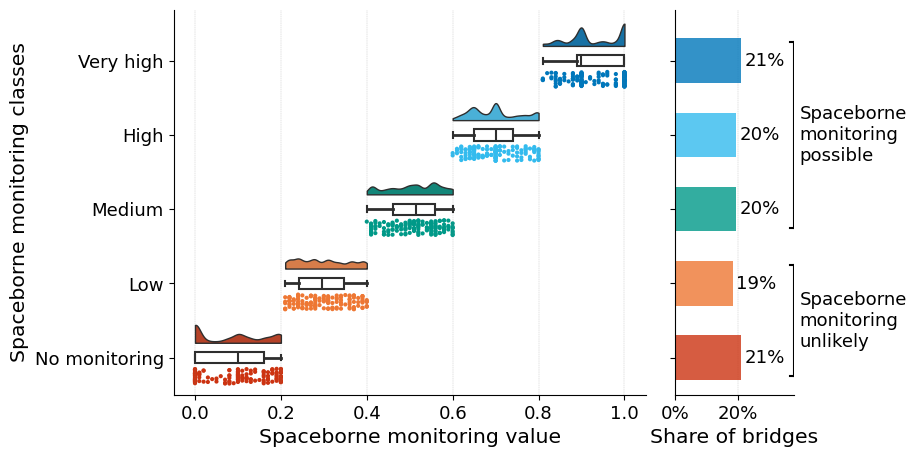

In [18]:

# Set font sizes for the figure
set_fonts_for_figure((8, 5))

# Create two subplots sharing y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), sharey=True,
                        gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Left subplot: Rainplot
pt.RainCloud(x="Spaceborne_monitoring_labels", y="Monitoring_2sc",
                data=bridges_gdf, palette=colors_ordered, bw=0.15,
                width_viol=.6, ax=ax1, orient="h", move=0.25)

# Customize left subplot
ax1.set_xlabel("Spaceborne monitoring value")
ax1.set_ylabel("Spaceborne monitoring classes")
ax1.set_xlim(-.05, 1.05)

# Force the y-tick labels to show properly
ax1.set_yticks(range(len(monitoring_labels)))
ax1.set_yticklabels(monitoring_labels)
ax1.tick_params(axis="x")

# Add grid for rainplot
ax1.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax1.set_axisbelow(True)

# Right subplot: Bar chart
bar_height = 0.6
for i, (label, prop) in enumerate(proportions.items()):
    ax2.barh(y=i, width=prop, height=bar_height,
            color=colors_ordered[i], alpha=0.8)
    # Add percentage labels at the end of bars
    ax2.text(prop + 0.01, i, f"{prop:.0%}",
            ha="left", va="center")

# Customize right subplot
ax2.set_xlabel("Share of bridges")
ax2.set_xlim(0, max(proportions) * 1.8)  # Extended to accommodate brackets
ax2.tick_params(axis="x")

# Format x-axis as percentages
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))

# Add grid for bar chart
ax2.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax2.set_axisbelow(True)

# Remove spines
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Add horizontal brackets to group categories (positioned on the right subplot)
# Define y-positions for the bracket groups (updated for new order)
unlikely_y = [3, 4]  # "No monitoring" and "Low" (now at bottom)
possible_y = [0, 1, 2]  # "Medium", "High", and "Very high" (now at top)

# Get the x position to place the brackets (to the right of the bars)
bracket_x = max(proportions) * 1.8  # Position on x-axis
text_x = bracket_x + 0.02  # Position for the text

# Draw the "Monitoring unlikely" bracket
ax2.plot(
    [bracket_x, bracket_x],
    [unlikely_y[0] - 0.25, unlikely_y[-1] + 0.25],
    "k-",
    linewidth=1.5,
)
# Add horizontal ends to the bracket (facing left)
ax2.plot(
    [bracket_x - 0.01, bracket_x],
    [unlikely_y[0] - 0.25, unlikely_y[0] - 0.25],
    "k-",
    linewidth=1.5,
)
ax2.plot(
    [bracket_x - 0.01, bracket_x],
    [unlikely_y[-1] + 0.25, unlikely_y[-1] + 0.25],
    "k-",
    linewidth=1.5,
)
# Add text
ax2.text(
    text_x,
    (unlikely_y[0] + unlikely_y[-1]) / 2,
    "Spaceborne\nmonitoring\nunlikely",
    ha="left",
    va="center",
    rotation=0
)

# Draw the "Monitoring possible" bracket
ax2.plot(
    [bracket_x, bracket_x],
    [possible_y[0] - 0.25, possible_y[-1] + 0.25],
    "k-",
    linewidth=1.5,
)
# Add horizontal ends to the bracket (facing left)
ax2.plot(
    [bracket_x - 0.01, bracket_x],
    [possible_y[0] - 0.25, possible_y[0] - 0.25],
    "k-",
    linewidth=1.5,
)
ax2.plot(
    [bracket_x - 0.01, bracket_x],
    [possible_y[-1] + 0.25, possible_y[-1] + 0.25],
    "k-",
    linewidth=1.5,
)
# Add text
ax2.text(
    text_x,
    (possible_y[0] + possible_y[-1]) / 2,
    "Spaceborne\nmonitoring\npossible",
    ha="left",
    va="center",
    rotation=0
)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig1c_space_monitoring.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()

plt.close()

# Fig.2 PS availability by parameters

## Fig.2a PS availability by material

### Read data

In [19]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig2a_ps_availability_by_material.csv"),
)

### Pre-processing

In [20]:
bridges_gdf["Material"] = "Other"
bridges_gdf.loc[
    (
        bridges_gdf["Material: Deck"].isin(
            ["Prestressed Concrete", "Reinforced Concrete"]
        )
    )
    & (bridges_gdf["Material: Piers/Pylons"] == "Reinforced Concrete"),
    "Material",
] = "Concrete"
bridges_gdf.loc[
    (bridges_gdf["Material: Deck"] == "Steel")
    & (bridges_gdf["Material: Piers/Pylons"] == "Steel"),
    "Material",
] = "Steel"
bridges_gdf.loc[
    (bridges_gdf["Material: Deck"] == "Steel")
    & (
        bridges_gdf["Material: Piers/Pylons"].isin(
            ["Prestressed Concrete", "Reinforced Concrete"]
        )
    ),
    "Material",
] = "Composite"

desired_order = ["Steel", "Concrete", "Composite", "Other"]


### Plot

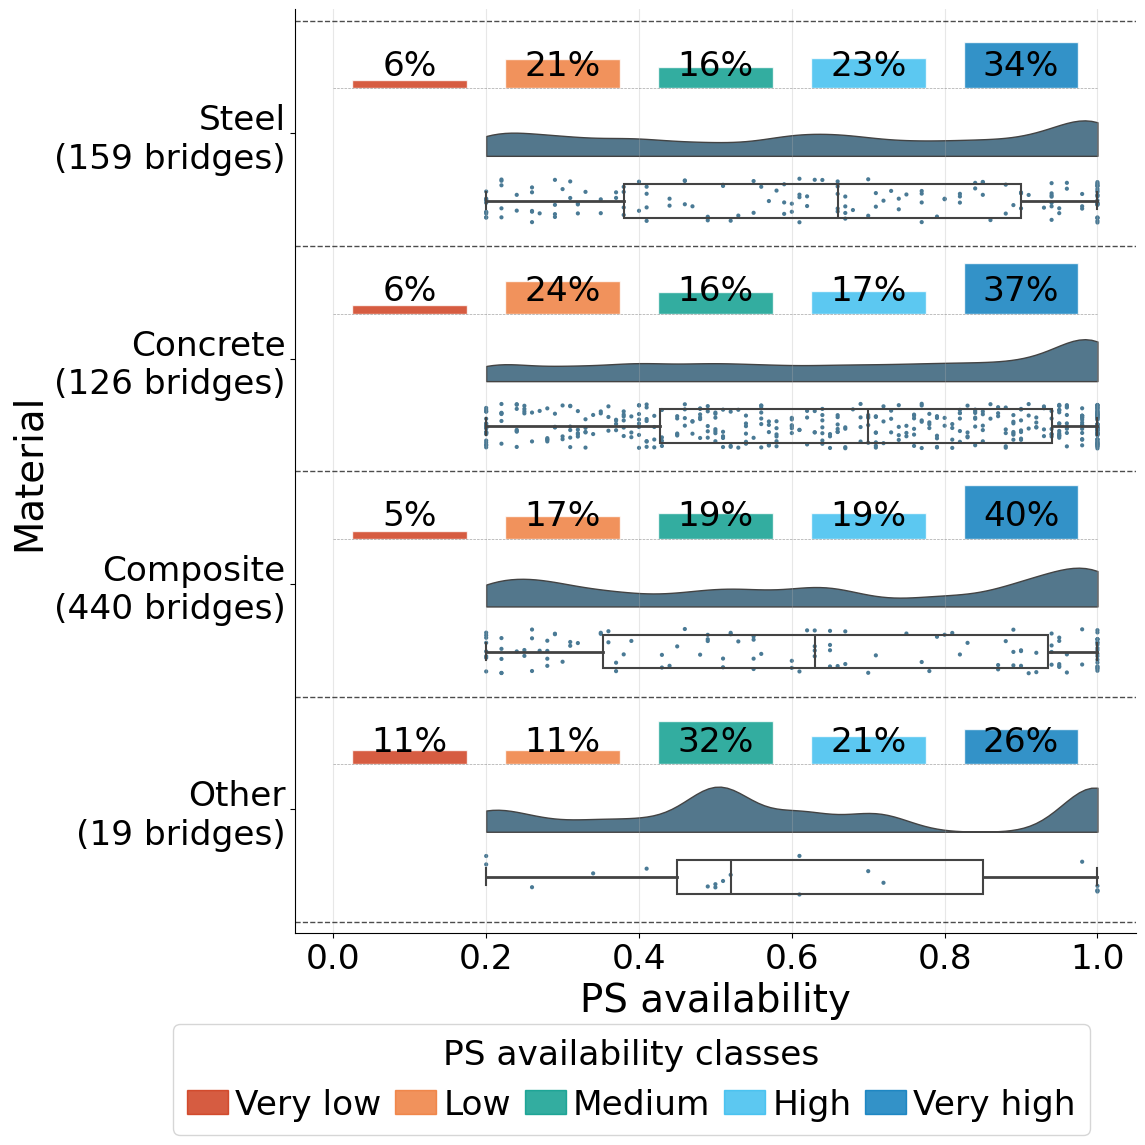

In [21]:
plot_ps_availability_with_distribution(
    bridges_gdf, "Material", desired_order, custom_cmap, plots_path, "fig2a"
)

## Fig.2b PS availability by bridge type

### Read data

In [22]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig2b_ps_availability_by_bridge_type.csv"),
)

### Pre-processing

In [23]:
desired_order = ["Arch", "Cable-Stayed", "Cantilever", "Truss", "Suspension"]

### Plot

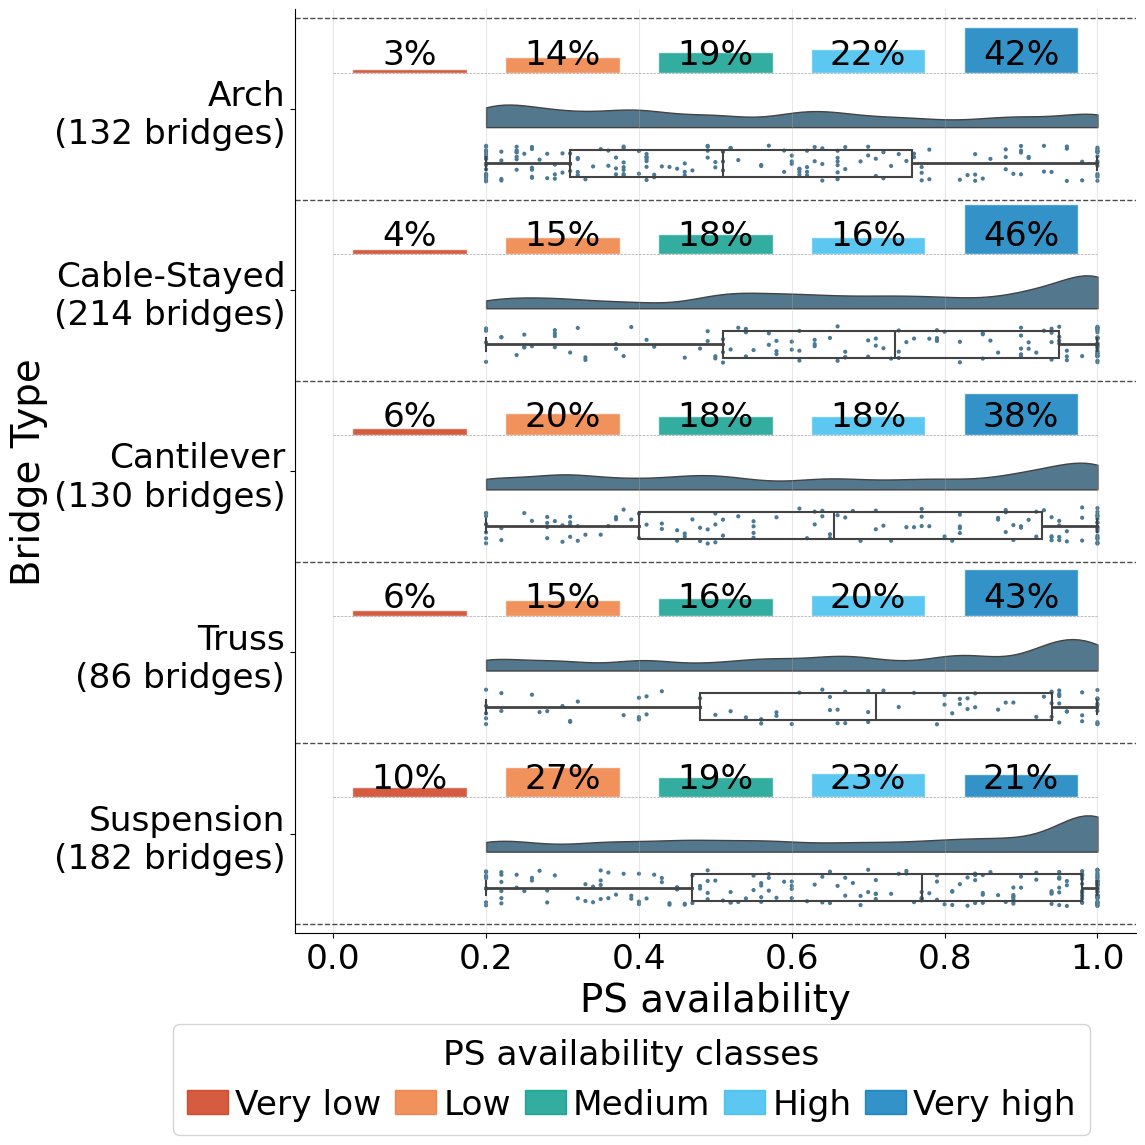

In [24]:
plot_ps_availability_with_distribution(
    bridges_gdf, "Bridge Type", desired_order, custom_cmap, plots_path, "fig2b"
)

## Fig.2c PS availability by bridge azimuth

### Read data

In [25]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig2c_ps_availability_by_azimuth.csv"),
)

### Pre-processing

In [26]:
bridges_gdf["Azimuth"] = pd.Categorical(
    bridges_gdf["Azimuth_numerical_class"],
    categories=[
        "N-S orientation",
        "Angled orientation",
        "E-W orientation",
    ],
    ordered=True,
)

desired_order = [
    "N-S orientation",
    "Angled orientation",
    "E-W orientation",
]

### Plot

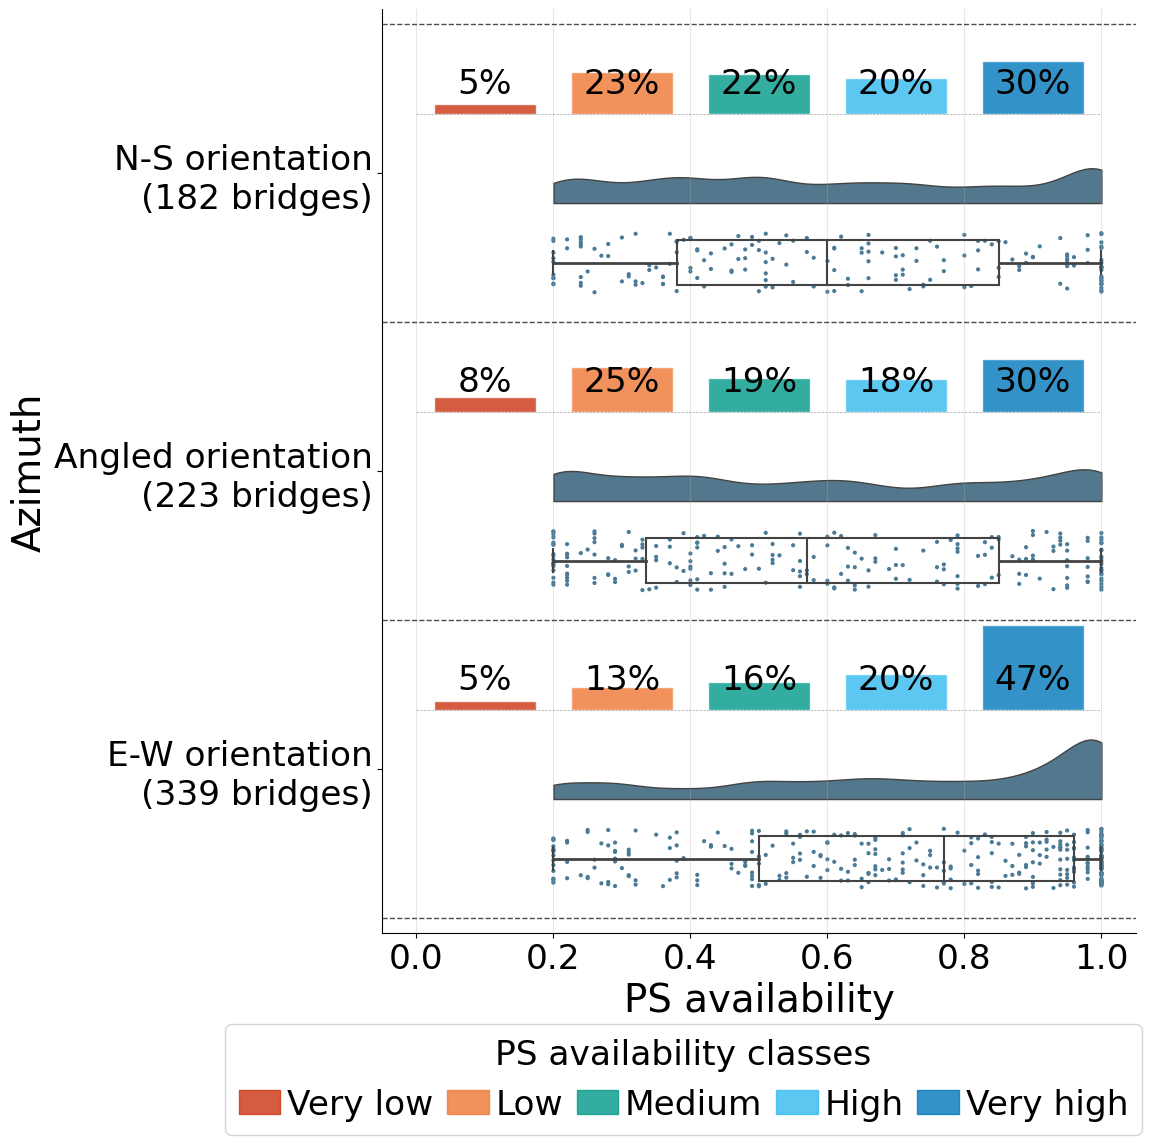

In [27]:
plot_ps_availability_with_distribution(
    bridges_gdf, "Azimuth", desired_order, custom_cmap, plots_path, "fig2c"
)

# Fig.3 SHM and spaceborne monitoring comparison

## Fig.3a Monitoring per continent

### Read data

In [28]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig3a_monitoring_by_continent.csv"),
)

### Pre-processing

In [29]:
# For spaceborne monitoring, create the unlikely/possible categories
space_mapping = {
    "No monitoring": "SNT_unlikely",
    "Low": "SNT_unlikely", 
    "Medium": "SNT_possible",
    "High": "SNT_possible",
    "Very High": "SNT_possible"
}
bridges_gdf["Space_category"] = bridges_gdf["Spaceborne monitoring class"].map(space_mapping)

# Create categorical labels for SHM for better hue handling
bridges_gdf["SHM_category"] = bridges_gdf["SHM-based monitoring"].map({
    0: "No SHM",
    1: "SHM Available"
})

# ADD GLOBAL SUMMARY as a new "region"
bridges_global = bridges_gdf.copy()
bridges_global["Region"] = "Global"  # Set all entries to "Global"

# Combine original data with global summary
bridges_gdf = pd.concat([bridges_gdf, bridges_global], ignore_index=True)


### Plot

/tmp/ipykernel_22730/3420062233.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


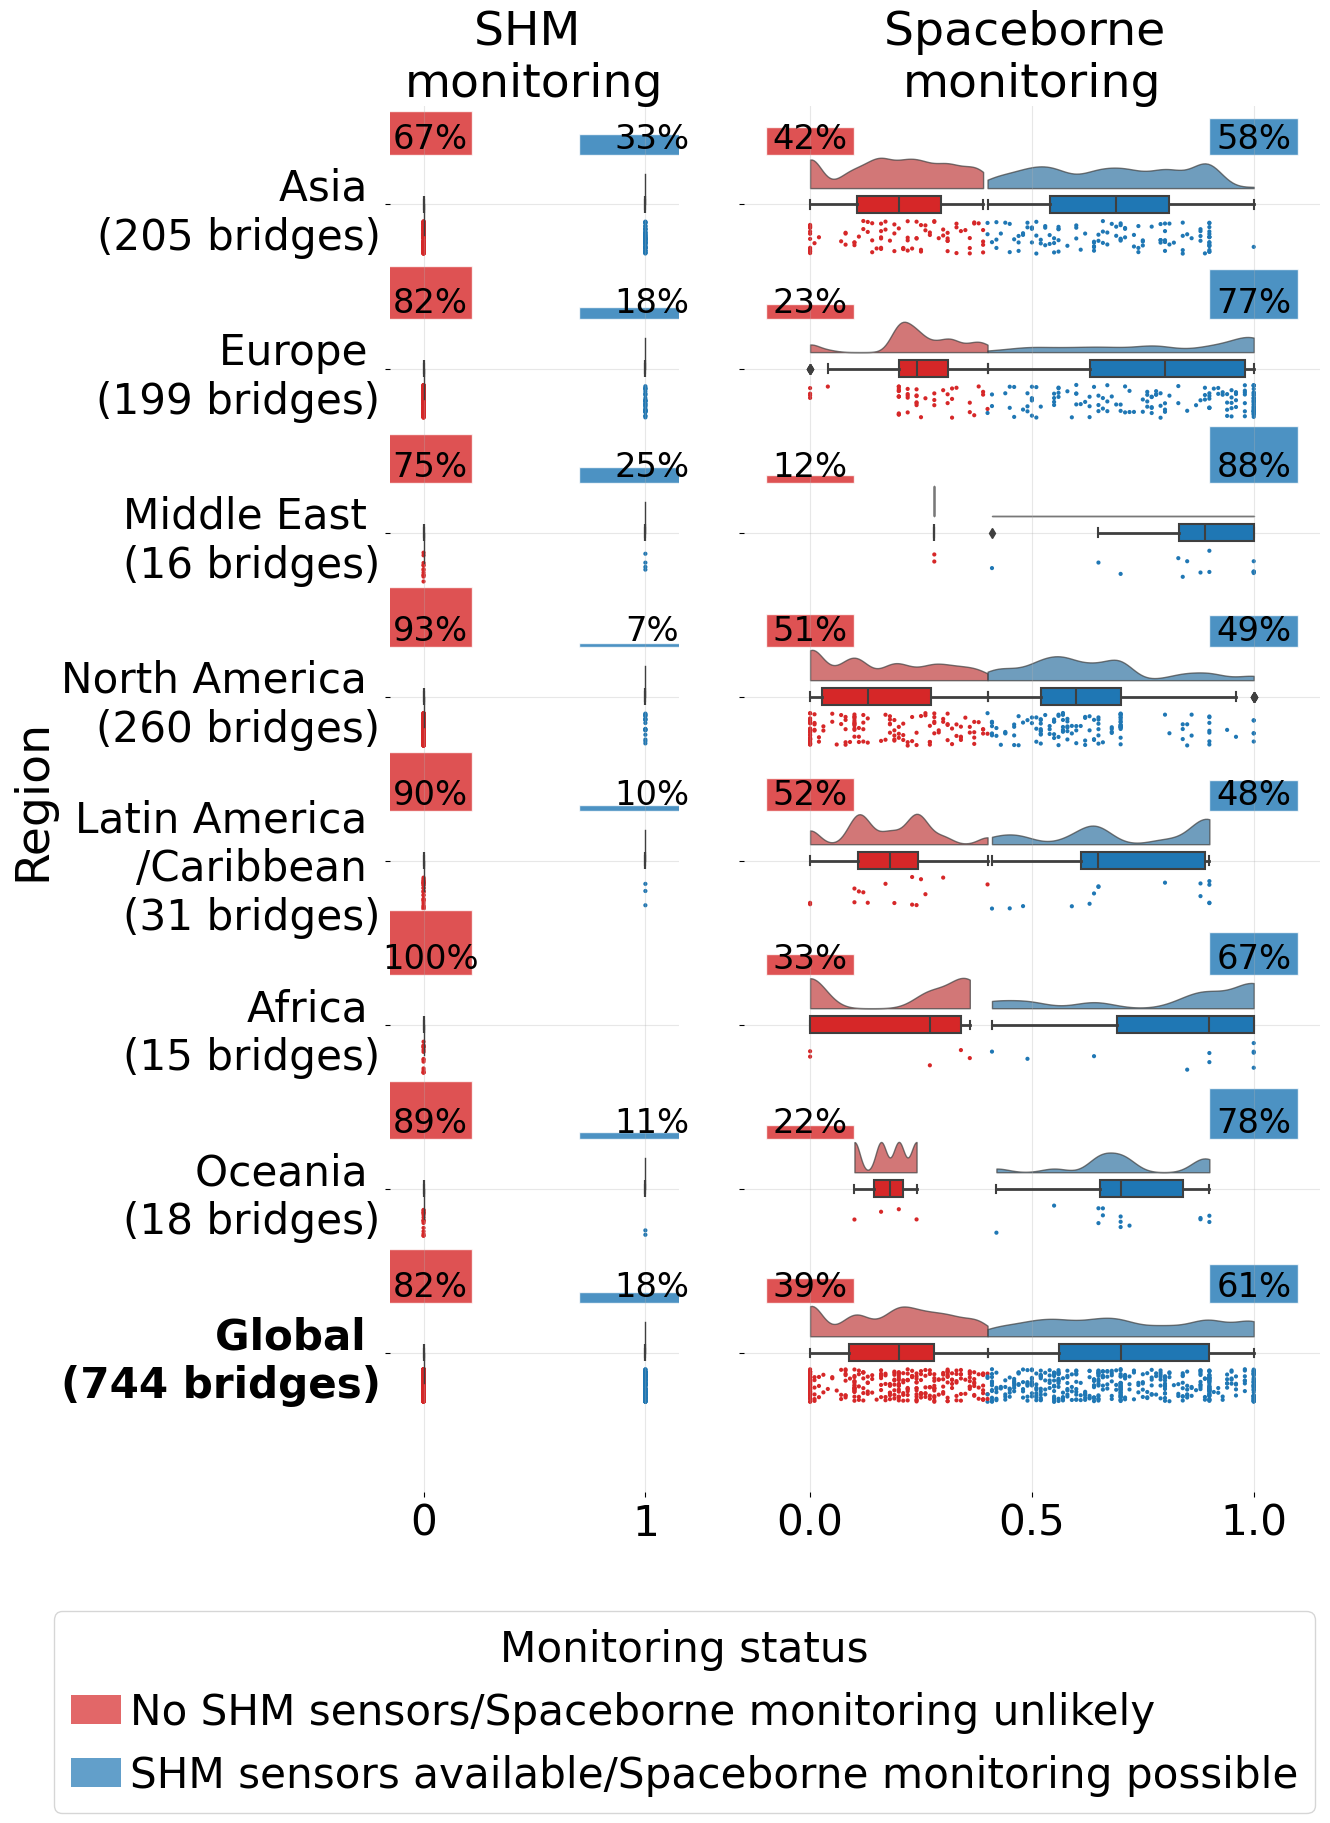

In [30]:

# Set font sizes for the figure
set_fonts_for_figure((12, 18))

# Define consistent color scheme: Red for No/Unlikely, Blue for Available/Possible
colors = ["#1f77b4", "#d62728"] 
colors_reverse = colors[::-1]  
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 18),
                                gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.15})

# Plot 1: SHM Monitoring Raincloud with hue
pt.RainCloud(
    x="Region", 
    y="SHM-based monitoring",
    hue="SHM_category",  # This splits each raincloud by SHM category
    data=bridges_gdf, 
    palette=colors,  # Red for No SHM, Blue for SHM Available
    bw=0.2,
    width_viol=0.37, 
    width_box=0.1,
    ax=ax1, 
    orient="h",
    move=0.2,
    alpha=0.7,
    offset=0.1,
    box_medianprops={"zorder": 11} # Ensure box median is on top 
)

ax1.set_xlabel("")
ax1.set_ylabel("Region")
ax1.set_title("SHM \nmonitoring")
ax1.set_xlim(-.15, 1.15)

# Plot 2: Spaceborne Monitoring Raincloud with hue
# Create a numeric version for the y-axis but keep categorical for hue
space_numeric_mapping = {"SNT_unlikely": 0, "SNT_possible": 1}
bridges_gdf["Space_numeric"] = bridges_gdf["Space_category"].map(space_numeric_mapping)

pt.RainCloud(
    x="Region", 
    y="Spaceborne monitoring",
    hue="Space_category",  # This splits each raincloud by space category
    data=bridges_gdf, 
    palette=colors_reverse,  # Red for unlikely, Blue for possible
    bw=0.2,
    width_viol=0.37, 
    width_box=0.1,
    ax=ax2, 
    orient="h",
    move=0.2,
    alpha=0.7,
    offset=0.1,
    box_medianprops={"zorder": 11} # Ensure box median is on top 
)

ax2.set_xlabel("")
ax2.set_title("Spaceborne \nmonitoring")
ax2.set_xlim(-.15, 1.15)
ax2.set_yticklabels([])  # Remove y-tick labels for the second plot
ax2.set_ylabel("")

# Add bar plots above raincloud plots
regions = list(bridges_gdf["Region"].unique())

# Extend y-axis to accommodate bars above raincloud plots
for ax in [ax1, ax2]:
    ax.set_ylim(len(regions) - 0.15, -0.6)

# Bar plotting parameters
bar_width = 0.4
bar_height_scale = 0.4  # Maximum height scaling for histogram bars

# For SHM (left subplot)
shm_bin_centers = [0, 1]  # Positions for "No SHM" and "SHM Available"

for i, region in enumerate(regions):
    region_data = bridges_gdf[bridges_gdf["Region"] == region]
    
    if len(region_data) > 0:
        # Calculate proportions for SHM classes
        shm_counts = region_data["SHM-based monitoring"].value_counts(normalize=True)
        
        # Y position - level where bars start
        y_bottom = i - 0.3
        
        # Create bars for each SHM class
        for j, (shm_val, color) in enumerate([(0, "#d62728"), (1, "#1f77b4")]):  # No SHM, SHM Available
            if shm_val in shm_counts:
                prop = shm_counts[shm_val]
                
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar
                bar_y_position = y_bottom - bar_actual_height / 2
                
                # Create bar
                ax1.barh(
                    y=bar_y_position,
                    width=bar_width*1.3,
                    height=bar_actual_height,
                    left=shm_bin_centers[j] - bar_width / 2 - 0.1,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label
                ax1.text(
                    shm_bin_centers[j]+.03,
                    y_bottom - 0.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size'] * 0.8,
                    color="black",
                )

# For Spaceborne (right subplot)  
space_bin_centers = [0, 1]  # Positions for "Unlikely" and "Possible"

for i, region in enumerate(regions):
    region_data = bridges_gdf[bridges_gdf["Region"] == region]
    
    if len(region_data) > 0:
        # Calculate proportions for spaceborne classes
        space_counts = region_data["Space_category"].value_counts(normalize=True)
        
        # Y position - level where bars start
        y_bottom = i - 0.3
        
        # Create bars for each spaceborne class
        for j, (space_class, color) in enumerate([("SNT_unlikely", "#d62728"), ("SNT_possible", "#1f77b4")]):
            if space_class in space_counts:
                prop = space_counts[space_class]
                
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar
                bar_y_position = y_bottom - bar_actual_height / 2
                
                # Create bar
                ax2.barh(
                    y=bar_y_position,
                    width=bar_width*.5,
                    height=bar_actual_height,
                    left=space_bin_centers[j] - bar_width / 4,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label
                ax2.text(
                    space_bin_centers[j],
                    y_bottom - 0.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size'] * 0.8,
                    color="black",
                )

# Add region labels with bridge counts
region_labels = []
for region in regions:
    total_count = len(bridges_gdf[bridges_gdf["Region"] == region])
    if region == "Latin America/Caribbean":
        region_label = f"Latin America \n/Caribbean \n({total_count} bridges)"
    else:
        region_label = f"{region} \n({total_count} bridges)"
    region_labels.append(region_label)

ax1.set_yticklabels(region_labels)

for i, (region, label) in enumerate(zip(regions, ax1.get_yticklabels())):
    if "Global" in region:
        label.set_fontweight('bold')

# Customize appearance
for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(True, alpha=0.3)

# Create custom legends with consistent colors
combined_legend_elements = [
    Patch(facecolor='#d62728', alpha=0.7, label='No SHM sensors/Spaceborne monitoring unlikely'),
    Patch(facecolor='#1f77b4', alpha=0.7, label='SHM sensors available/Spaceborne monitoring possible')
]

# REMOVE AUTOMATIC LEGENDS created by pt.RainCloud
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add the legend to the figure (not individual axes)
fig.legend(
    handles=combined_legend_elements,
    title="Monitoring status",
    loc="lower center",
    bbox_to_anchor=(0.37, -0.08),
    ncol=1,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)
plt.tight_layout()
plt.savefig(
    os.path.join(plots_path, "fig3a_monitoring_by_continent.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()



## Fig.3b SHM and spaceborne monitoring overlap

### Read data

In [31]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig3b_SHM_and_space_monitoring_overlap.csv"),
)

### Pre-processing

In [32]:
# Create column with spaceborne monitoring class
create_class_column(
    df=bridges_gdf,
    source_col="Spaceborne monitoring",
    target_col="Spaceborne monitoring class",
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.01],
    labels=["No monitoring", "Low", "Medium", "High", "Very High"],
    right=False,
    include_lowest=True,
)

# Set font sizes for the figure
set_fonts_for_figure((15, 14))

# Define colors for the 5 spaceborne monitoring categories
color_dict_monitoring = {
    "No monitoring": "#CC3311",
    "Low": "#EE7733",
    "Medium": "#009988", 
    "High": "#33BBEE",
    "Very High": "#0077BB",
}

# Create colors list in the order of categories
monitoring_categories = ["No monitoring", "Low", "Medium", "High", "Very High"]
colors = [color_dict_monitoring[cat] for cat in monitoring_categories]

# Create a binary SHM column
bridges_gdf["SHM_binary"] = bridges_gdf["SHM-based monitoring"].map({0: "No SHM", 1: "SHM Available"})

# Order the spaceborne monitoring categories
bridges_gdf["Spaceborne monitoring class ordered"] = pd.Categorical(
    bridges_gdf["Spaceborne monitoring class"], 
    categories=monitoring_categories, 
    ordered=True
)

### Plot

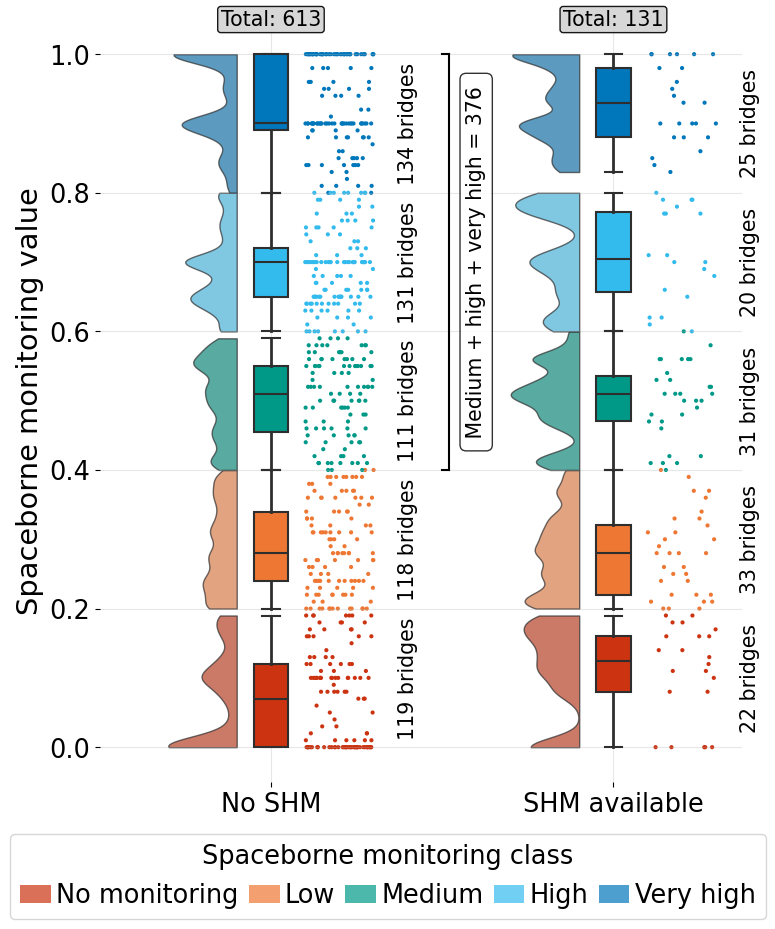

In [33]:


# Set font sizes for the figure
set_fonts_for_figure((8, 10))

# Set up the plot with single subplot
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# Plot: Spaceborne Monitoring with hue by spaceborne monitoring categories
pt.RainCloud(
    x="SHM-based monitoring", 
    y="Spaceborne monitoring",
    hue="Spaceborne monitoring class ordered",  # Hue by spaceborne categories
    data=bridges_gdf, 
    palette=colors,  # Same colors for consistency
    bw=0.2,
    width_viol=0.4, 
    width_box=0.1,
    ax=ax, 
    orient="v",
    move=0.2,
    alpha=0.7,
    offset=0.1,  # Adjust offset to avoid overlap
    box_medianprops={"zorder": 11} # Ensure box median is on top 

)

        
ax.set_xlabel("")
# ax.set_title("Spaceborne\nMonitoring")
ax.set_ylabel("Spaceborne monitoring value")

# Calculate cross-tabulation for count annotations
cross_tab = pd.crosstab(
    bridges_gdf["SHM_binary"], 
    bridges_gdf["Spaceborne monitoring class ordered"]
)


# Add count annotations for vertical plot
shm_categories = ["No SHM", "SHM Available"]

for i, shm_cat in enumerate(shm_categories):

    if shm_cat in cross_tab.index:
        total_bridges = cross_tab.loc[shm_cat].sum()
        
        # Add total count above each x-category (vertical orientation)
        ax.text(i, 1.05, f"Total: {total_bridges}", 
                ha="center", va="center", fontsize=plt.rcParams['font.size']*.8,
                bbox=dict(boxstyle="round,pad=0.15", facecolor="lightgray", alpha=0.9),
                )
        
        # Add individual category counts stacked vertically above the total
        y_start = 0.10
        for j, (space_cat, color) in enumerate(zip(monitoring_categories, colors)):
            if space_cat in cross_tab.columns:
                count = cross_tab.loc[shm_cat, space_cat]
                if count > 0:
                    # Position each count above the previous one
                    ax.text(i+.4, y_start + (j * 0.2), f"{count} bridges", 
                            ha="center", va="center", fontsize=plt.rcParams['font.size']*.8,
                            color="black", rotation=90,
                            # bbox=dict(boxstyle="round,pad=0.2", 
                            # facecolor="white", 
                            # edgecolor=color,  # Added colored border
                            # linewidth=1.5,    # Optional: adjust border thickness
                            # alpha=0.8))
                    )

# Set x labels
shm_categories = ["No SHM", "SHM available"]
ax.set_xticklabels(shm_categories)

# # # Extend y-axis to accommodate count annotations
# current_ylim = ax.get_ylim()
# print(current_ylim)
# # # ax.set_ylim(current_ylim[0], 1.2)

# # # Extend x-axis to accommodate count annotations
# current_xlim = ax.get_xlim()
# print(current_xlim)
# # ax.set_xlim(current_xlim[0], current_xlim[1] + 0.5)

# Customize appearance
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.grid(True, alpha=0.3)

# Create custom legend with spaceborne monitoring categories
legend_elements = [
    Patch(facecolor=color, alpha=0.7, label=category.capitalize()) 
    for category, color in zip(monitoring_categories, colors)
]

# Remove automatic legends created by pt.RainCloud
if ax.get_legend():
    ax.get_legend().remove()

# Add the legend to the figure
fig.legend(
    handles=legend_elements,
    title="Spaceborne monitoring class",
    loc="lower center",
    bbox_to_anchor=(.5, 0.05),
    ncol=5,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)

# Add summary bracket annotation for Medium+High+Very High in No SHM
if "No SHM" in cross_tab.index:
    medium_high_veryhigh_count = (
        cross_tab.loc["No SHM", "Medium"] + 
        cross_tab.loc["No SHM", "High"] + 
        cross_tab.loc["No SHM", "Very High"]
    )
    
    if medium_high_veryhigh_count > 0:
        # Find the y-positions for Medium, High, Very High annotations (No SHM side)
        # These correspond to j=2, j=3, j=4 in your loop above
        bracket_bottom = 0.05 + (2 * 0.2)  # Medium position
        bracket_top = 0.15 + (4 * 0.2)     # Very High position
        bracket_x_pos = 0.52  # Position to the right of the annotations
        
        # Main horizontal line (bracket span)
        ax.plot(
            [bracket_x_pos, bracket_x_pos],
            [bracket_bottom - 0.05, bracket_top + 0.05],
            "k-",
            linewidth=1.5,
        )
        
        # Add vertical ends to the bracket
        ax.plot(
            [bracket_x_pos, bracket_x_pos - 0.02],
            [bracket_bottom - 0.05, bracket_bottom - 0.05],
            "k-",
            linewidth=1.5,
        )
        ax.plot(
            [bracket_x_pos, bracket_x_pos - 0.02],
            [bracket_top + 0.05, bracket_top + 0.05],
            "k-",
            linewidth=1.5,
        )
        
        # Add text label
        ax.text(
            bracket_x_pos + 0.05,
            (bracket_bottom + bracket_top) / 2,
            f" Medium + high + very high = {medium_high_veryhigh_count} ",
            ha="left",
            va="center",
            rotation=90,
            fontsize=plt.rcParams['font.size']*.8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
        )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for legend

plt.savefig(
    os.path.join(plots_path, "fig3b_SHM_and_space_monitoring_overlap.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

# Fig.4 Structural vulnerability

## Fig.4a Structural vulnerability distribution by region

### Read data

In [34]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig4a_vulnerability_by_continent.csv"),
)

### Pre-processing

In [35]:

# Create a new column for Vulnerability_norm_class
bridges_gdf["Vulnerability_norm_class"] = pd.cut(
    bridges_gdf["Vulnerability_norm"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
    labels=["Low", "Medium-Low", "Medium", "Medium-High", "High"],
    right=True,
    include_lowest=True,
)

# Define colors using the same scheme as your updated plots
alpha = 0.8
colors_ordered = [
    to_rgba("#CC3311", alpha),  # Very Low (red)
    to_rgba("#EE7733", alpha),  # Low (orange)
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#0077BB", alpha),  # Very High (blue)
]

colors_ordered = colors_ordered[::-1]  # Reverse to have Very High on top

# Define the vulnerability labels in the same order as the colormap
vulnerability_labels = ["Low", "Medium-Low", "Medium", "Medium-High", "High"]

# ADD GLOBAL SUMMARY as a new "region"
bridges_global = bridges_gdf.copy()
bridges_global["Region"] = "Global"  # Set all entries to "Global"

# Combine original data with global summary
bridges_gdf = pd.concat([bridges_gdf, bridges_global], ignore_index=True)

# Get unique regions and their order
desired_order = bridges_gdf["Region"].unique().tolist()

# Update region names for better display
region_mapping = {
    "Latin America/Caribbean": "Latin America\n/Caribbean"
}
bridges_gdf["Region_display"] = bridges_gdf["Region"].map(region_mapping).fillna(bridges_gdf["Region"])
desired_order_display = [region_mapping.get(region, region) for region in desired_order]



# Use a single color for the raincloud plot
one_colour = [to_rgba("#4A7A95", 0.8)]


### Plot

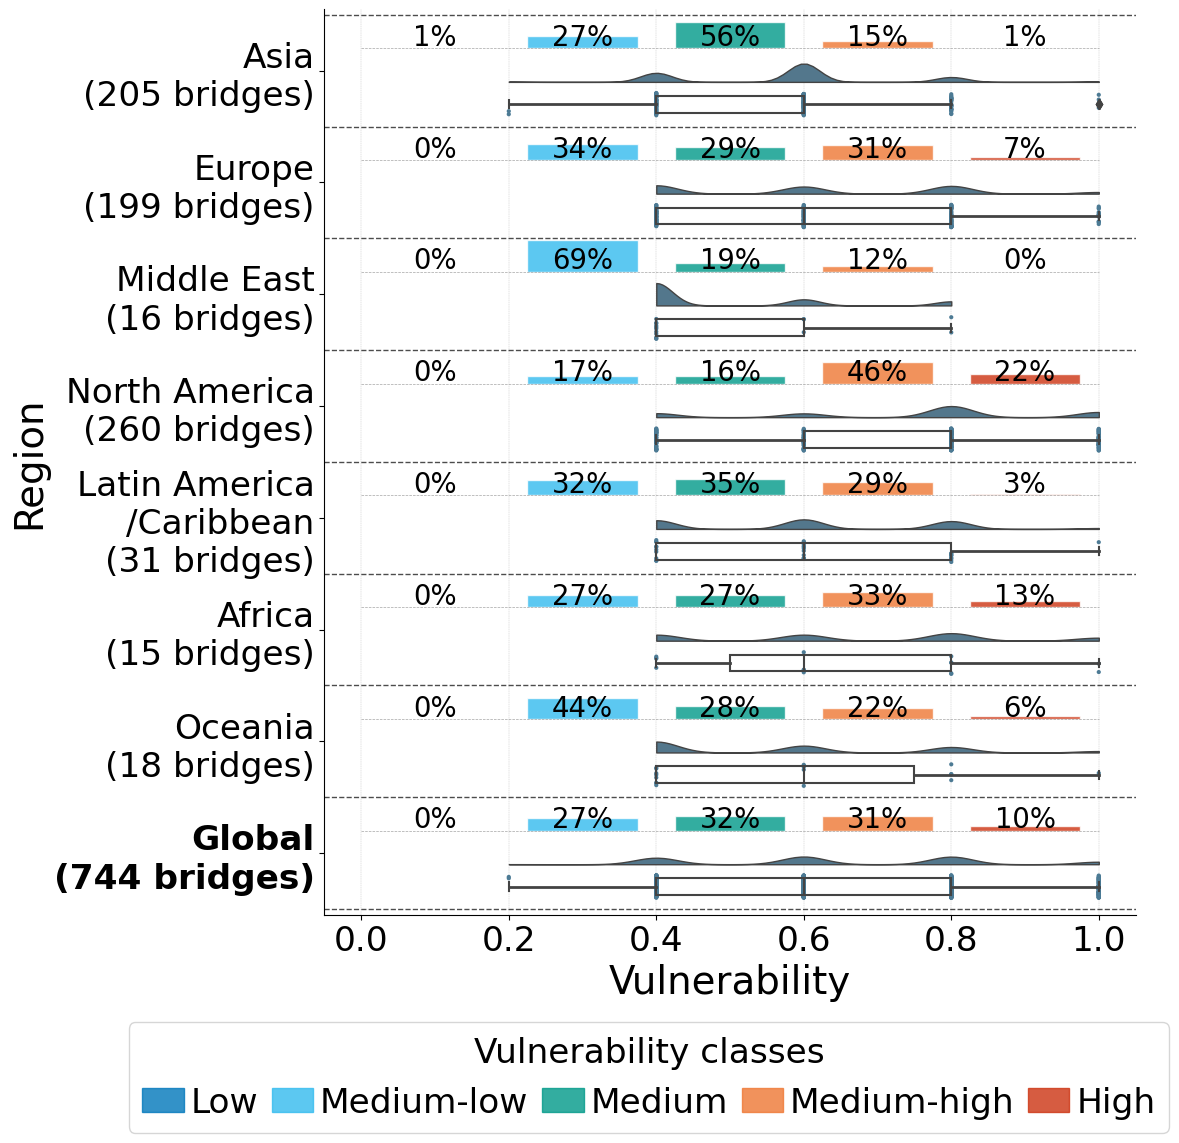

In [36]:

# Set font sizes for the figure
set_fonts_for_figure((12, 12))

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Create raincloud plot for all regions
pt.RainCloud(
    x="Region_display",
    y="Vulnerability_norm",
    data=bridges_gdf,
    palette=one_colour,
    bw=0.15,
    width_viol=0.4,
    ax=ax,
    orient="h",
    move=0,
)

# Now overlay histogram bars for each region
bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9]
bar_width = 0.15
bar_height_scale = 0.42  # Maximum height scaling for histogram bars

for i, region in enumerate(desired_order):
    region_display = region_mapping.get(region, region)
    region_data = bridges_gdf[bridges_gdf["Region"] == region]
    
    if len(region_data) > 0:
        # Calculate proportions for this region
        proportions = region_data["Vulnerability_norm_class"].value_counts(normalize=True)
        proportions = proportions.reindex(vulnerability_labels, fill_value=0)
        
        # Y position - bottom level where all bars start
        y_bottom = i - 0.5  # Bottom edge of all bars for this region
        
        # Create histogram bars above the raincloud for this region
        for j, (label, prop) in enumerate(proportions.items()):
            if prop > 0:
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar so its bottom starts at y_bottom and extends upward
                bar_y_position = y_bottom - bar_actual_height / 2
                
                # Create bar
                ax.barh(
                    y=bar_y_position,
                    width=bar_width,
                    height=-bar_actual_height,
                    left=bin_centers[j] - bar_width / 2,
                    color=colors_ordered[j],
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label 
                ax.text(
                    bin_centers[j],
                    y_bottom-.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                    # weight="bold"
                )
            else:

                # Add percentage label 
                ax.text(
                    bin_centers[j],
                    y_bottom-.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                    # weight="bold"
                )

# Customize the plot
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(len(desired_order) - 0.75, -0.85)  # Extended to accommodate bars above
ax.set_xlabel("Vulnerability")
ax.set_ylabel("Region")

# Update y-tick labels to include bridge counts
y_labels = []
for region in desired_order:
    region_display = region_mapping.get(region, region)
    count = len(bridges_gdf[bridges_gdf["Region"] == region])
    y_labels.append(f"{region_display}\n({count:,} bridges)")

ax.set_yticks([i - 0.3 for i in range(len(desired_order))])
ax.set_yticklabels(y_labels)

for i, (region, label) in enumerate(zip(desired_order, ax.get_yticklabels())):
    if "Global" in region:
        label.set_fontweight('bold')

# Add grid
ax.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax.set_axisbelow(True)

# Add horizontal lines for bar plots
for i in range(-1, len(desired_order)):
    ax.hlines(
        y=i + 0.5,
        xmin=0,
        xmax=1,
        color="grey",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )

# Add horizontal lines between regions
for i in range(-2, len(desired_order)):
    ax.axhline(y=i + 1.2, color="black", linestyle="--", linewidth=1, alpha=0.7)

# Add legend below the plot
legend_elements = [
    plt.Rectangle(
        (0, 0), 1, 1, color=colors_ordered[i], alpha=0.8, label=vulnerability_labels[i].capitalize()
    )
    for i in range(len(vulnerability_labels))
]
ax.legend(
    handles=legend_elements,
    title="Vulnerability classes",
    bbox_to_anchor=(0.4, -0.1),
    loc="upper center",
    ncol=5,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,

)

# Clean styling
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(
    os.path.join(plots_path, "fig4a_vulnerability_by_continent.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

## Fig.4b Monitoring and structural vulnerability

### Read data

In [37]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig4b_monitoring_vulnerability.csv"),
)

### Pre-processing

In [38]:
# Define alpha
alpha = 0.7

# Define colors (reordered to match new label order - Very high at top)
colors_ordered = [
    to_rgba("#0077BB", alpha),  # Very high (blue) - now first
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#EE7733", alpha),  # Low (orange)
    to_rgba("#CC3311", alpha),  # No monitoring (red) - now last
]

# Create custom labels (Very high at top, No monitoring at bottom)
vulnerability_classes  = ["Very High", "High", "Medium", "Low", "Very Low"]
vulnerability_classes_italian_guideliness_labels = ["High", "Medium-High", "Medium", "Medium-Low", "Low"]

# Calculate counts for each vulnerability class
vuln_counts = bridges_gdf["Vulnerability_norm_class"].value_counts()

# Create labels with counts in brackets
vulnerability_labels_with_counts = []
for i, vuln_class in enumerate(vulnerability_classes):
    vuln_class_label = vulnerability_classes_italian_guideliness_labels[i]
    count = vuln_counts.get(vuln_class, 0)  # Get count, default to 0 if not found
    vulnerability_labels_with_counts.append(f"{vuln_class_label.capitalize()}\nvulnerability\n({count} bridges)")
    

# Create a mapping from original labels to custom labels for spaceborne
spaceborne_label_mapping = {
    "[0, 0.2]": "No monitoring",
    "(0.2, 0.4]": "Low", 
    "(0.4, 0.6]": "Medium",
    "(0.6, 0.8]": "High",
    "(0.8, 1.0]": "Very high"
}

# Create SHM mapping (assuming 0 = No monitoring, 1 = Very high)
shm_label_mapping = {
    0: "No monitoring",
    1: "Very high"
}

# Define color palettes
# For spaceborne: all 5 colors
spaceborne_plot_colors = [
    to_rgba("#CC3311", alpha),  # red (No monitoring)
    to_rgba("#EE7733", alpha),  # orange (Low)  
    to_rgba("#009988", alpha),  # green (Medium)
    to_rgba("#33BBEE", alpha),  # light blue (High)
    to_rgba("#0077BB", alpha),  # navy blue (Very high)
]

spaceborne_plot_colors_rainplot = [
    to_rgba("#CC3311", alpha),  # red (No monitoring)
    to_rgba("#EE7733", alpha),  # orange (Low)  
    to_rgba("#0077BB", alpha),  # navy blue (Very high)
    to_rgba("#009988", alpha),  # green (Medium)
    to_rgba("#33BBEE", alpha),  # light blue (High)


]
# For SHM: only first (Very high - blue) and last (No monitoring - red) colors
shm_colors = [colors_ordered[0], colors_ordered[4]]  # Blue and red


### Plot

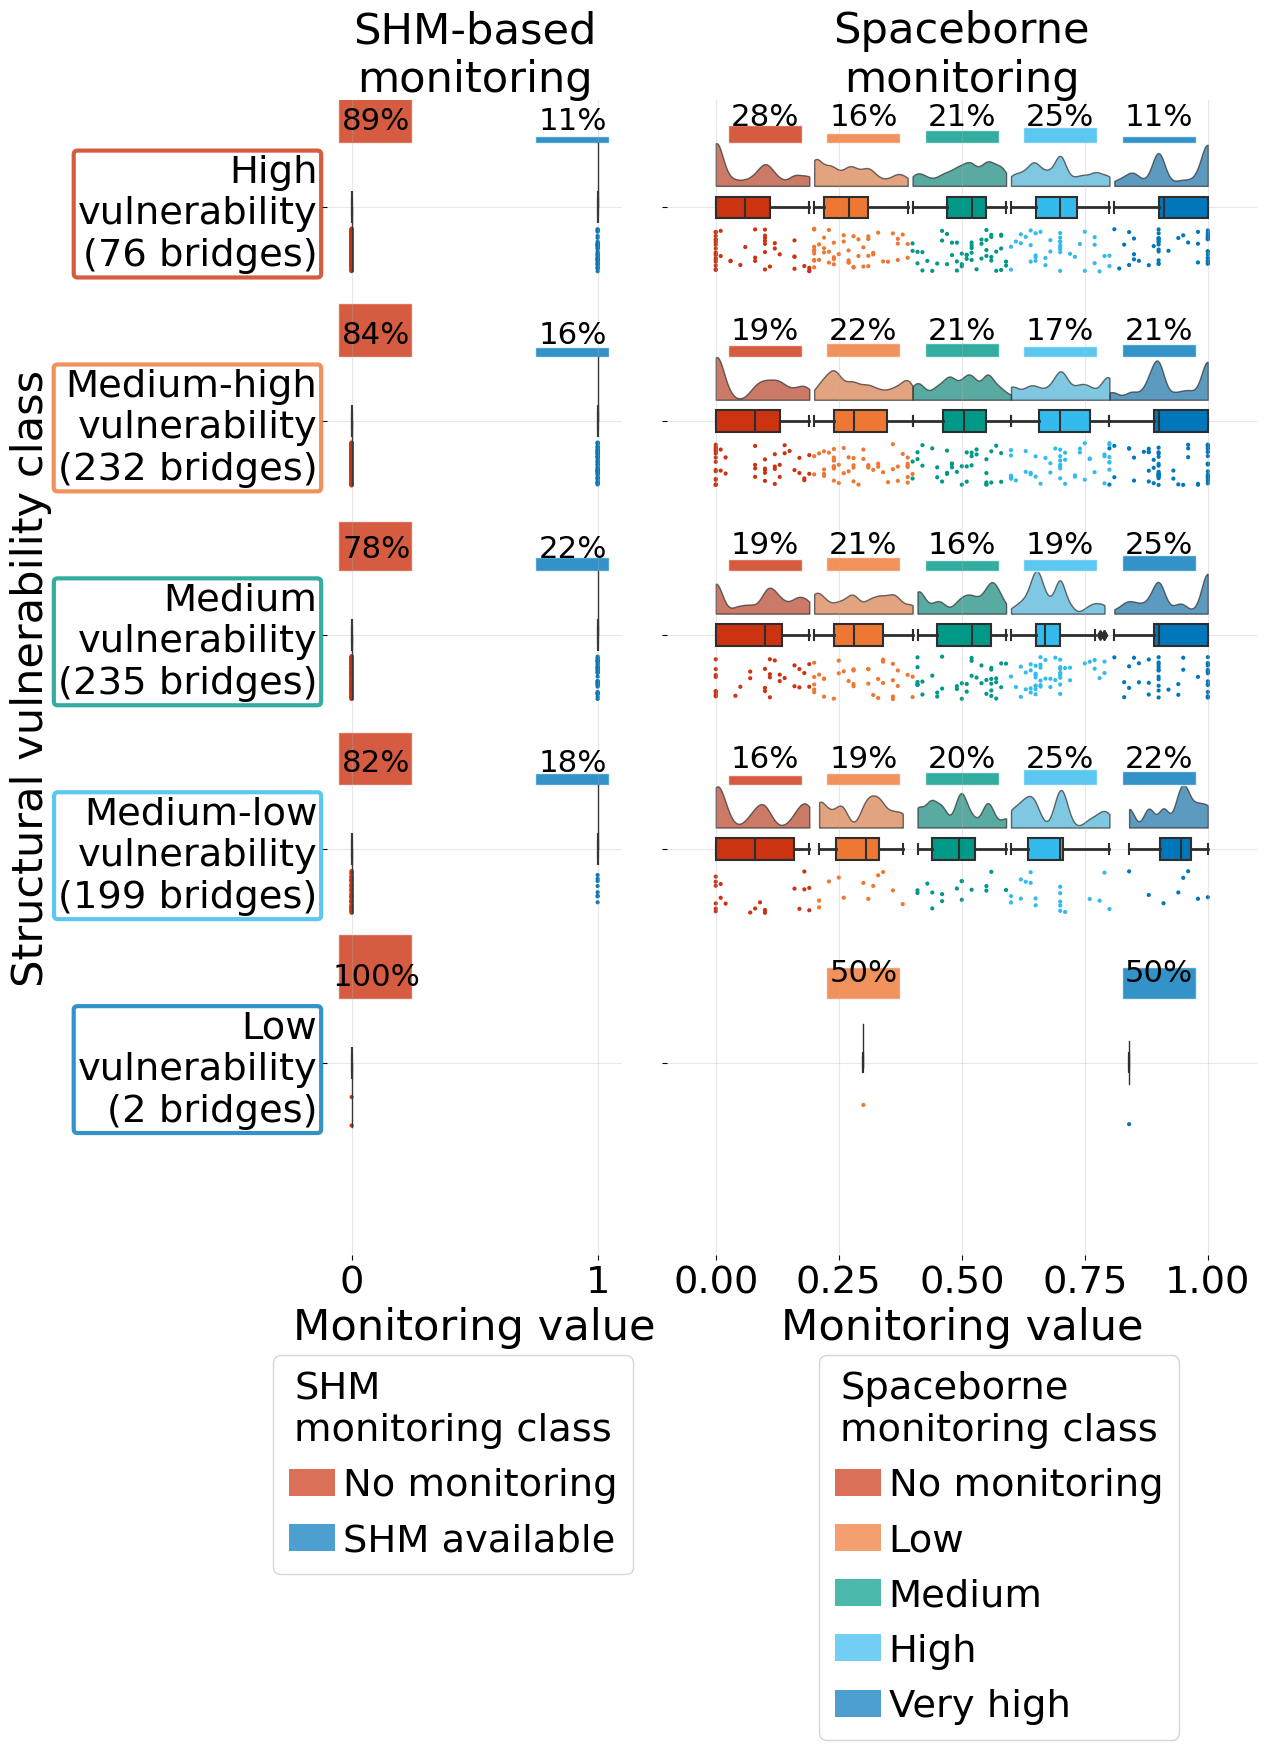

In [39]:
# Set font sizes for the figure
set_fonts_for_figure((12, 15))  # Uncomment if you have this function

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 15), 
                            gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.1})

# Plot 1: SHM Monitoring Raincloud with hue
pt.RainCloud(
    x="Vulnerability_norm_class", 
    y="SHM-based monitoring",
    hue="SHM-based monitoring class",  # This splits each raincloud by SHM category
    data=bridges_gdf, 
    palette=shm_colors,  # Blue for Very high, Red for No monitoring
    bw=0.2,
    width_viol=0.6, 
    ax=ax1, 
    orient="h",
    move=0.2,
    alpha=0.7,
    box_medianprops={"zorder": 11} # Ensure box median is on top 
)

ax1.set_xlabel("Monitoring value")
ax1.set_ylabel("Structural vulnerability class")
ax1.set_yticks(range(len(vulnerability_labels_with_counts)))
ax1.set_yticklabels(vulnerability_labels_with_counts)
# Get the tick label objects and set black text with colored boxes
for i, (label, color) in enumerate(zip(ax1.get_yticklabels(), spaceborne_plot_colors)):
    label.set_color("black")  # Set text to black
    label.set_bbox(dict(boxstyle="round,pad=0.1", 
                    facecolor="white", 
                    edgecolor=color,
                    linewidth=3,
                    alpha=0.8))  # Add colored border
ax1.set_title("SHM-based\nmonitoring")
ax1.set_xlim(-0.1, 1.1)

# Plot 2: Spaceborne Monitoring Raincloud with hue
pt.RainCloud(
    x="Vulnerability_norm_class", 
    y="Spaceborne monitoring",
    hue="Spaceborne monitoring class",  # This splits each raincloud by spaceborne category
    data=bridges_gdf, 
    palette=spaceborne_plot_colors_rainplot,  # All 5 colors
    bw=0.2,
    width_viol=0.4, 
    width_box=0.1,
    ax=ax2, 
    orient="h",
    move=0.2,
    alpha=0.7,
    offset=0.1,  # Adjust offset to avoid overlap
    box_medianprops={"zorder": 11} # Ensure box median is on top 
)

ax2.set_xlabel("Monitoring value")
ax2.set_title("Spaceborne\nmonitoring")
ax2.set_ylabel("")  # Remove y-label for right subplot
ax2.set_yticklabels([])  # Remove y-tick labels for right subplot
ax2.set_xlim(-0.1, 1.1)


# Extend y-axis to accommodate bars above violin plots
ax1.set_ylim(len(vulnerability_classes) - 0.1, -.5)
ax2.set_ylim(len(vulnerability_classes) - 0.1, -.5)
# Add bar plots above each violin plot

# For SHM (left subplot)
shm_bin_centers = [0.1, 0.9]  # Positions for "No monitoring" and "Very high"
bar_width = 0.15
bar_height_scale = 0.3  # Maximum height scaling for histogram bars

for i, vuln_class in enumerate(vulnerability_classes):
    vuln_data = bridges_gdf[bridges_gdf["Vulnerability_norm_class"] == vuln_class]
    
    if len(vuln_data) > 0:
        # Calculate proportions for SHM classes
        shm_counts = vuln_data["SHM-based monitoring"].value_counts(normalize=True)
        
        # Y position - level where bars start
        y_bottom = i - 0.3  
        
        # Create bars for each SHM class
        for j, (shm_val, color) in enumerate([(0, shm_colors[1]), (1, shm_colors[0])]):  # No monitoring, Very high
            if shm_val in shm_counts:
                prop = shm_counts[shm_val]
                
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar
                bar_y_position = y_bottom - bar_actual_height / 2
                
                # Create bar
                ax1.barh(
                    y=bar_y_position,
                    width=bar_width*2,
                    height=bar_actual_height,
                    left=shm_bin_centers[j] - bar_width / 2 - 0.08,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label
                ax1.text(
                    shm_bin_centers[j],
                    y_bottom-.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                )
                
# For Spaceborne (right subplot)
space_bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9] # Positions for 5 monitoring levels

for i, vuln_class in enumerate(vulnerability_classes):
    vuln_data = bridges_gdf[bridges_gdf["Vulnerability_norm_class"] == vuln_class]
    
    if len(vuln_data) > 0:
        # Calculate proportions for spaceborne classes
        space_counts = vuln_data["Spaceborne monitoring class"].value_counts(normalize=True)
        
        # Map classes to proportions in correct order
        space_labels_ordered = ["No monitoring", "Low", "Medium", "High", "Very High"]
        
        # Y position - level where bars start
        y_bottom = i - 0.3

        # Create bars for each spaceborne class
        for j, (space_class, color) in enumerate(zip(space_labels_ordered, spaceborne_plot_colors)):  # Reverse order for correct color mapping
            if space_class in space_counts:
                prop = space_counts[space_class]
                
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar
                bar_y_position = y_bottom - bar_actual_height / 2
                                
                # Create bar
                ax2.barh(
                    y=bar_y_position,
                    width=bar_width,
                    height=bar_actual_height,
                    left=space_bin_centers[j] - bar_width / 2,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label
                ax2.text(
                    space_bin_centers[j],
                    y_bottom-.12,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                )


# Customize appearance
for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(True, alpha=0.3)

# Create custom legends
shm_legend_elements = [
    Patch(facecolor='#CC3311', alpha=0.7, label='No monitoring'),
    Patch(facecolor='#0077BB', alpha=0.7, label='SHM available')
]

spaceborne_legend_elements = [
    Patch(facecolor='#0077BB', alpha=0.7, label='Very high'),
    Patch(facecolor='#33BBEE', alpha=0.7, label='High'),
    Patch(facecolor='#009988', alpha=0.7, label='Medium'),
    Patch(facecolor='#EE7733', alpha=0.7, label='Low'),
    Patch(facecolor='#CC3311', alpha=0.7, label='No monitoring')
]

# REMOVE AUTOMATIC LEGENDS created by pt.RainCloud
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Add legends to each subplot
ax1.legend(
    handles=shm_legend_elements,
    title="SHM\nmonitoring class",
    loc="upper right",
    bbox_to_anchor=(1.1, -.07),
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)

ax2.legend(
    handles=spaceborne_legend_elements[::-1],
    title="Spaceborne\nmonitoring class",
    loc="upper right",
    bbox_to_anchor=(.9, -.07),
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig4b_monitoring_vulnerability.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()

plt.close()

# Fig.5 Risk analysis

## Fig.5a Risk distribution by region

### Read data

In [40]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig5a_risk_by_continent.csv"),
)
bridges_gdf.columns = bridges_gdf.columns.str.replace('Multi-hazard', 'Geo-hazard')


### Pre-processing

In [41]:
# Create a new column for Geo-hazard_risk_shm_class
bridges_gdf["Geo-hazard_risk_shm_class"] = pd.cut(
    bridges_gdf["Geo-hazard_risk_shm"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
    labels=["Very Low", "Low", "Medium", "High", "Very High"],
    right=True,
    include_lowest=True,
)

# Define colors using the same scheme as your updated plots
alpha = 0.8
colors_ordered = [
    to_rgba("#CC3311", alpha),  # Very Low (red)
    to_rgba("#EE7733", alpha),  # Low (orange)
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#0077BB", alpha),  # Very High (blue)
]

# Define the risk labels in the same order as the colormap
risk_labels = ["Very Low", "Low", "Medium", "High", "Very High"]

# ADD GLOBAL SUMMARY as a new "region"
bridges_global = bridges_gdf.copy()
bridges_global["Region"] = "Global"  # Set all entries to "Global"

# Combine original data with global summary
bridges_gdf = pd.concat([bridges_gdf, bridges_global], ignore_index=True)

# Get unique regions and their order
desired_order = bridges_gdf["Region"].unique().tolist()

# Update region names for better display
region_mapping = {
    "Latin America/Caribbean": "Latin America\n/Caribbean"
}
bridges_gdf["Region_display"] = bridges_gdf["Region"].map(region_mapping).fillna(bridges_gdf["Region"])
desired_order_display = [region_mapping.get(region, region) for region in desired_order]

# Use a single color for the raincloud plot
one_colour = [to_rgba("#4A7A95", 0.8)]


### Plot

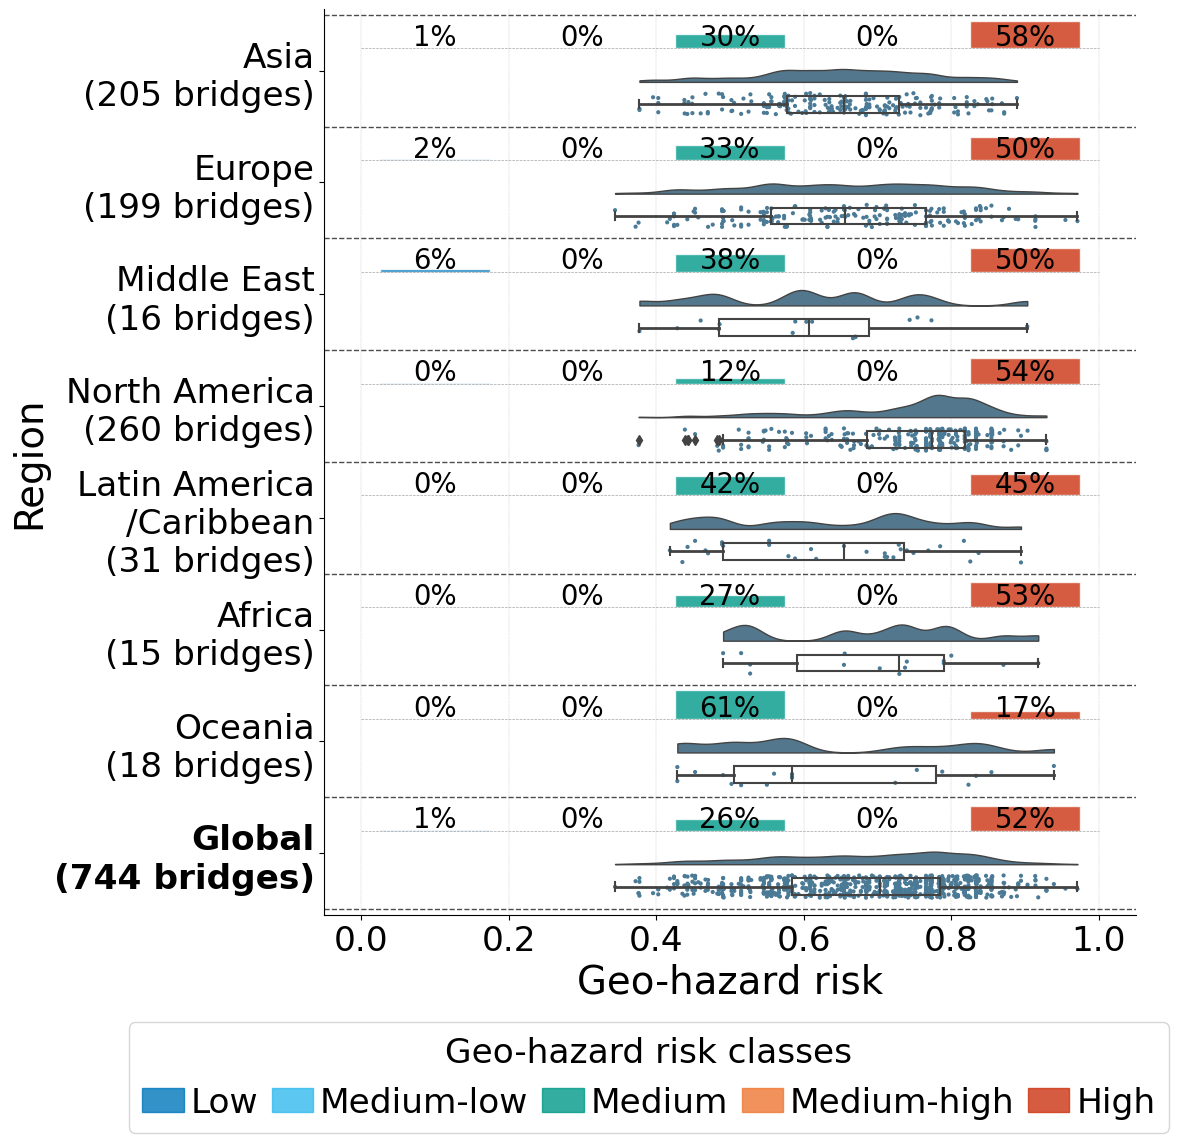

In [42]:
# Set font sizes for the figure
set_fonts_for_figure((12, 12))

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Create raincloud plot for all regions
pt.RainCloud(
    x="Region_display",
    y="Geo-hazard_risk_shm",
    data=bridges_gdf,
    palette=one_colour,
    bw=0.15,
    width_viol=0.4,
    ax=ax,
    orient="h",
    move=0,
)

# Now overlay histogram bars for each region
bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9]
bar_width = 0.15
bar_height_scale = 0.42  # Maximum height scaling for histogram bars

for i, region in enumerate(desired_order):
    region_display = region_mapping.get(region, region)
    region_data = bridges_gdf[bridges_gdf["Region"] == region]
    
    if len(region_data) > 0:
        # Calculate proportions for this region
        proportions = region_data["Geo-hazard_risk_shm_class"].value_counts(normalize=True)
        proportions = proportions.reindex(vulnerability_labels, fill_value=0)
        
        # Y position - bottom level where all bars start
        y_bottom = i - 0.5  # Bottom edge of all bars for this region
        
        # Create histogram bars above the raincloud for this region
        for j, (label, prop) in enumerate(proportions.items()):
            if prop > 0:
                # Calculate actual bar height
                bar_actual_height = bar_height_scale * prop
                
                # Position bar so its bottom starts at y_bottom and extends upward
                bar_y_position = y_bottom - bar_actual_height / 2
                
                # Create bar
                ax.barh(
                    y=bar_y_position,
                    width=bar_width,
                    height=-bar_actual_height,
                    left=bin_centers[j] - bar_width / 2,
                    color=colors_ordered[::-1][j],
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label 
                ax.text(
                    bin_centers[j],
                    y_bottom-.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                    # weight="bold"
                )
            else:

                # Add percentage label 
                ax.text(
                    bin_centers[j],
                    y_bottom-.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*.8,
                    color="black",
                    # weight="bold"
                )

# Customize the plot
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(len(desired_order) - 0.75, -0.85)  # Extended to accommodate bars above
ax.set_xlabel("Geo-hazard risk")
ax.set_ylabel("Region")

# Update y-tick labels to include bridge counts
y_labels = []
for region in desired_order:
    region_display = region_mapping.get(region, region)
    count = len(bridges_gdf[bridges_gdf["Region"] == region])
    y_labels.append(f"{region_display}\n({count:,} bridges)")

ax.set_yticks([i - 0.3 for i in range(len(desired_order))])
ax.set_yticklabels(y_labels)

for i, (region, label) in enumerate(zip(desired_order, ax.get_yticklabels())):
    if "Global" in region:
        label.set_fontweight('bold')

# Add grid
ax.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax.set_axisbelow(True)

# Add horizontal lines for bar plots
for i in range(-1, len(desired_order)):
    ax.hlines(
        y=i + 0.5,
        xmin=0,
        xmax=1,
        color="grey",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )

# Add horizontal lines between regions
for i in range(-2, len(desired_order)):
    ax.axhline(y=i + 1.2, color="black", linestyle="--", linewidth=1, alpha=0.7)

# Add legend below the plot
legend_elements = [
    plt.Rectangle(
        (0, 0), 1, 1, color=colors_ordered[::-1][i], alpha=0.8, label=vulnerability_labels[i].capitalize()
    )
    for i in range(len(vulnerability_labels))
]
ax.legend(
    handles=legend_elements,
    title="Geo-hazard risk classes",
    bbox_to_anchor=(0.4, -0.1),
    loc="upper center",
    ncol=5,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,

)

# Clean styling
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(
    os.path.join(plots_path, "fig5a_risk_by_continent.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

## Fig.5b Monitoring and geo-hazard risk

### Read data

In [43]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig5b_monitoring_risk.csv"),
)
bridges_gdf.columns = bridges_gdf.columns.str.replace('Multi-hazard', 'Geo-hazard')


### Pre-processing

In [44]:
# Define alpha
alpha = 0.7

# Define risk classes and colors
risk_classes = ["Very High", "High", "Medium", "Low", "Very Low"]

# Calculate counts for each risk class
risk_counts = bridges_gdf["Geo-hazard_risk_shm_class"].value_counts()

# Create labels with counts in brackets
risk_labels_with_counts = []
for risk_class in risk_classes:
    count = risk_counts.get(risk_class, 0)
    risk_labels_with_counts.append(f"{risk_class.capitalize()}\nrisk ({count}\nbridges)")
    
    
# Calculate counts for each risk class
risk_counts_combined = bridges_gdf["Geo-hazard_risk_com_class"].value_counts()

# Create labels with counts in brackets
risk_labels_with_counts_combined = []
for risk_class in risk_classes:
    count = risk_counts_combined.get(risk_class, 0)
    risk_labels_with_counts_combined.append(f"{risk_class.capitalize()}\nrisk ({count}\nbridges)")

# Create SHM monitoring classes
create_class_column(
    df=bridges_gdf,
    source_col="SHM-based monitoring",
    target_col="Monitoring_shm_class",
    bins=[0, 0.5, 1.01],
    labels=["No monitoring", "SHM available"],
    right=False,
    include_lowest=True,
)

# Create combined monitoring values
# For bridges with SHM: assign values in range 1.0-1.2 
# For bridges without SHM: use their spaceborne monitoring values
bridges_gdf["Combined_monitoring_value"] = bridges_gdf.apply(
    lambda row: (
        1.1 if row["Monitoring_shm_class"] == "SHM available"  # Special high value for SHM
        else row["Spaceborne monitoring"]  # Use spaceborne value if no SHM
    ),
    axis=1,
)

# Create combined monitoring classes
def create_combined_monitoring_class(row):
    if row["Monitoring_shm_class"] == "SHM available":
        return "SHM available"
    else:
        # Use spaceborne monitoring classes for non-SHM bridges
        return row["Spaceborne monitoring class"]

bridges_gdf["Combined_monitoring_class"] = bridges_gdf.apply(create_combined_monitoring_class, axis=1)

# Convert to categorical to control order
combined_categories_order = ["No monitoring", "Low", "Medium", "High", "Very High", "SHM available"]
bridges_gdf["Combined_monitoring_class"] = pd.Categorical(
    bridges_gdf["Combined_monitoring_class"], 
    categories=combined_categories_order, 
    ordered=True
)

# Define color palettes
# For SHM: Binary colors
shm_colors = [
    to_rgba("#CC3311", alpha),  # No monitoring (red)
    to_rgba("#0077BB", alpha),  # SHM available (blue)
]

# For combined: 6 categories (5 spaceborne + 1 SHM) - use dictionary for precise mapping
combined_colors_dict = {
    "No monitoring": to_rgba("#CC3311", alpha),   # Red
    "Low": to_rgba("#EE7733", alpha),             # Orange  
    "Medium": to_rgba("#009988", alpha),          # Green
    "High": to_rgba("#33BBEE", alpha),            # Light blue
    "Very High": to_rgba("#0077BB", alpha),       # Blue
    "SHM available": to_rgba("#8B008B", alpha),   # Purple
}

# For combined: 6 categories (5 spaceborne + 1 SHM)
combined_colors = [
    to_rgba("#CC3311", alpha),  # No monitoring (red)
    to_rgba("#EE7733", alpha),  # Low (orange)  
    to_rgba("#009988", alpha),  # Medium (green)
    to_rgba("#33BBEE", alpha),  # High (light blue)
    to_rgba("#0077BB", alpha),  # Very high (blue)
    to_rgba("#8B008B", alpha),  # SHM available (dark magenta/purple)
]


In [45]:
# Print those rows where SHM-based monitoring class is No SHM but Spaceborne monitoring class is Very high
bridges_gdf[
    (bridges_gdf["SHM-based monitoring class"] == "No SHM") & 
    (bridges_gdf["Spaceborne monitoring class"] == "Very High")
]

ID  Geo-hazard_risk_shm Geo-hazard_risk_shm_class  Geo-hazard_risk_com  \
48    72             0.584053                    Medium             0.551253   
53    77             0.799196                      High             0.741084   
96   120             0.709897                      High             0.645304   
118  142             0.789824                      High             0.789824   
131  155             0.739750                      High             0.612393   
..   ...                  ...                       ...                  ...   
730  778             0.629595                      High             0.538299   
731  779             0.709736                      High             0.545389   
733  781             0.729553                      High             0.591688   
734  782             0.489205                    Medium             0.446473   
736  784             0.650875                      High             0.574410   

    Geo-hazard_risk_com_class  SHM-based monitoring  \
48                     Medium                     0   
53                       High                     0   
96                       High                     0   
118                      High                     0   
131                      High                     0   
..                        ...                   ...   
730                    Medium                     0   
731                    Medium                     0   
733                    Medium                     0   
734                    Medium                     0   
736                    Medium                     0   

    SHM-based monitoring class  Spaceborne monitoring  \
48                      No SHM                   0.81   
53                      No SHM                   0.96   
96                      No SHM                   0.81   
118                     No SHM                   0.96   
131                     No SHM                   0.85   
..                         ...                    ...   
730                     No SHM                   0.98   
731                     No SHM                   1.00   
733                     No SHM                   0.89   
734                     No SHM                   0.90   
736                     No SHM                   0.84   

    Spaceborne monitoring class Monitoring_shm_class  \
48                    Very High        No monitoring   
53                    Very High        No monitoring   
96                    Very High        No monitoring   
118                   Very High        No monitoring   
131                   Very High        No monitoring   
..                          ...                  ...   
730                   Very High        No monitoring   
731                   Very High        No monitoring   
733                   Very High        No monitoring   
734                   Very High        No monitoring   
736                   Very High        No monitoring   

     Combined_monitoring_value Combined_monitoring_class  
48                        0.81                 Very High  
53                        0.96                 Very High  
96                        0.81                 Very High  
118                       0.96                 Very High  
131                       0.85                 Very High  
..                         ...                       ...  
730                       0.98                 Very High  
731                       1.00                 Very High  
733                       0.89                 Very High  
734                       0.90                 Very High  
736                       0.84                 Very High  

[134 rows x 12 columns]

### Plot

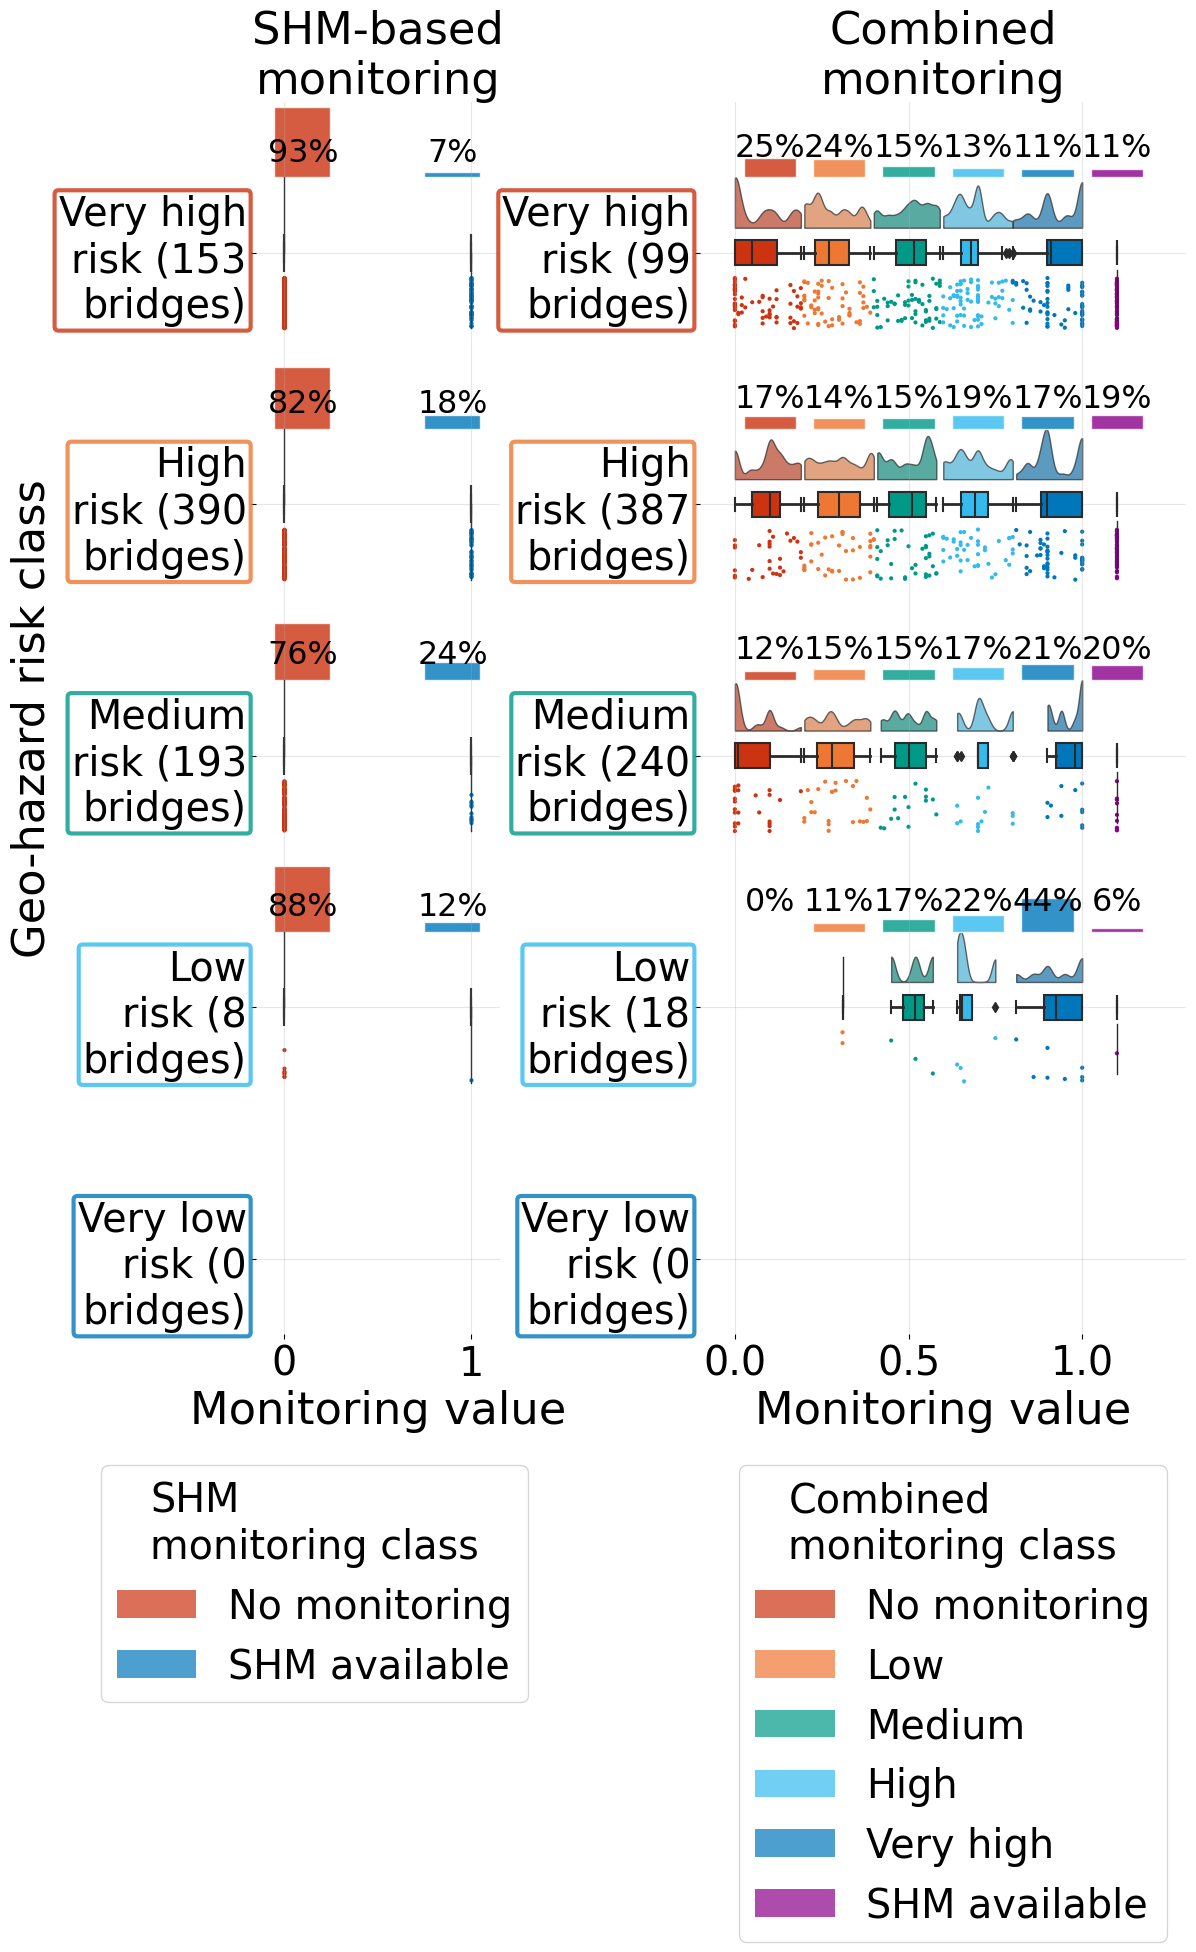

In [46]:
# Set font sizes for the figure
set_fonts_for_figure((12, 16))  # Uncomment if you have this function

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 16), 
                                gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.55})

# Plot 1: SHM Monitoring Raincloud
pt.RainCloud(
    x="Geo-hazard_risk_shm_class", 
    y="SHM-based monitoring",
    hue="Monitoring_shm_class",
    data=bridges_gdf, 
    palette=shm_colors,
    bw=0.2,
    width_viol=0.6, 
    ax=ax1, 
    orient="h",
    move=0.2,
    alpha=0.7,
    box_medianprops={"zorder": 11}
)

ax1.set_xlabel("Monitoring value")
ax1.set_ylabel("Geo-hazard risk class")
ax1.set_yticks(range(len(risk_labels_with_counts)))
ax1.set_yticklabels(risk_labels_with_counts)
# Get the tick label objects and set their colors
# for i, (label, color) in enumerate(zip(ax1.get_yticklabels(), combined_colors[:-1])):
#     label.set_color(color) 
for i, (label, color) in enumerate(zip(ax1.get_yticklabels(), combined_colors[:-1])):
    label.set_color("black")  # Set text to black
    label.set_bbox(dict(boxstyle="round,pad=0.1", 
                    facecolor="white", 
                    edgecolor=color,
                    linewidth=3,
                    alpha=0.8))  # Add colored border
ax1.set_title("SHM-based\nmonitoring")
ax1.set_xlim(-0.15, 1.15)

# Plot 2: Combined Monitoring Raincloud
pt.RainCloud(
    x="Geo-hazard_risk_com_class", 
    y="Combined_monitoring_value",
    hue="Combined_monitoring_class",
    data=bridges_gdf, 
    palette=combined_colors_dict,
    bw=0.2,
    width_viol=0.4, 
    width_box=0.1,
    ax=ax2, 
    orient="h",
    move=0.2,
    alpha=0.7,
    offset=0.1,
    box_medianprops={"zorder": 11}
)

ax2.set_xlabel("Monitoring value")
ax2.set_title("Combined\nmonitoring")
ax2.set_ylabel("")
ax2.set_yticks(range(len(risk_labels_with_counts_combined)))
ax2.set_yticklabels(risk_labels_with_counts_combined)
# Get the tick label objects and set their colors
# for i, (label, color) in enumerate(zip(ax2.get_yticklabels(), combined_colors[:-1])):
#     label.set_color(color)  
for i, (label, color) in enumerate(zip(ax2.get_yticklabels(), combined_colors[:-1])):
    label.set_color("black")  # Set text to black
    label.set_bbox(dict(boxstyle="round,pad=0.1", 
                    facecolor="white", 
                    edgecolor=color,
                    linewidth=3,
                    alpha=0.8))  # Add colored border
ax2.set_xlim(-0.1, 1.3)  # Extended to accommodate SHM values at 1.1

# Extend y-axis to accommodate bars above violin plots
ax1.set_ylim(4.3, -0.6)
ax2.set_ylim(4.3, -0.6)
y_limits = ax1.get_ylim()

# Add bar plots above each violin plot
# For SHM (left subplot)
shm_bin_centers = [0.1, 0.9]  # Positions for "No monitoring" and "SHM available"
bar_width = 0.15
bar_height_scale = 0.3

for i, risk_class in enumerate(risk_classes):
    risk_data = bridges_gdf[bridges_gdf["Geo-hazard_risk_shm_class"] == risk_class]
    
    if len(risk_data) > 0:
        # Calculate proportions for SHM classes
        shm_counts = risk_data["Monitoring_shm_class"].value_counts(normalize=True)
        
        y_bottom = i - 0.3
        
        # Create bars for each SHM class
        shm_classes = ["No monitoring", "SHM available"]
        for j, (shm_class, color) in enumerate(zip(shm_classes, shm_colors)):
            if shm_class in shm_counts:
                prop = shm_counts[shm_class]
                
                bar_actual_height = bar_height_scale * prop
                bar_y_position = y_bottom - bar_actual_height / 2
                
                ax1.barh(
                    y=bar_y_position,
                    width=bar_width*2,
                    height=bar_actual_height,
                    left=shm_bin_centers[j] - bar_width / 2 - 0.08,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                ax1.text(
                    shm_bin_centers[j],
                    y_bottom - 0.1,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size'] * 0.8,
                    color="black",
                )

# For Combined (right subplot)
combined_bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]  # 6 positions including SHM

for i, risk_class in enumerate(risk_classes):
    risk_data = bridges_gdf[bridges_gdf["Geo-hazard_risk_com_class"] == risk_class]
    
    if len(risk_data) > 0:
        # Calculate proportions for combined monitoring classes
        combined_counts = risk_data["Combined_monitoring_class"].value_counts(normalize=True)
        
        # Define the order of combined classes
        combined_classes_ordered = ["No monitoring", "Low", "Medium", "High", "Very High", "SHM available"]
        
        y_bottom = i - 0.3

        # Create bars for each combined class
        for j, (combined_class, color) in enumerate(zip(combined_classes_ordered, combined_colors)):
            if combined_class in combined_counts:
                prop = combined_counts[combined_class]
                
                bar_actual_height = bar_height_scale * prop
                bar_y_position = y_bottom - bar_actual_height / 2
                                
                ax2.barh(
                    y=bar_y_position,
                    width=bar_width,
                    height=bar_actual_height,
                    left=combined_bin_centers[j] - bar_width / 2,
                    color=color,
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                ax2.text(
                    combined_bin_centers[j],
                    y_bottom - 0.12,
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size'] * 0.8,
                    color="black",
                )

# Customize appearance
for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(True, alpha=0.3)

# Create custom legends
shm_legend_elements = [
    Patch(facecolor='#CC3311', alpha=0.7, label='No monitoring'),
    Patch(facecolor='#0077BB', alpha=0.7, label='SHM available')
]

combined_legend_elements = [
    Patch(facecolor='#8B008B', alpha=0.7, label='SHM available'),  # Dark magenta for SHM
    Patch(facecolor='#0077BB', alpha=0.7, label='Very high'),      # Blue for spaceborne very high
    Patch(facecolor='#33BBEE', alpha=0.7, label='High'),          # Light blue
    Patch(facecolor='#009988', alpha=0.7, label='Medium'),        # Green
    Patch(facecolor='#EE7733', alpha=0.7, label='Low'),           # Orange
    Patch(facecolor='#CC3311', alpha=0.7, label='No monitoring')  # Red
]

# Remove automatic legends created by pt.RainCloud
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Add legends to each subplot
ax1.legend(
    handles=shm_legend_elements,
    title="SHM\nmonitoring class",
    loc="upper right",
    bbox_to_anchor=(1.2, -0.09),
)

ax2.legend(
    handles=combined_legend_elements[::-1],  # Reverse order so SHM is at top
    title="Combined\nmonitoring class",
    loc="upper right",
    bbox_to_anchor=(1, -0.09),
)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig5b_monitoring_risk.jpg"),
    bbox_inches="tight",
    dpi=600,
)

plt.show()

plt.close()

# Fig.6 Change in risk

## Fig.6a Change in risk box plot

### Read data

In [47]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig6a_box_plot_risk.csv"),
)
bridges_gdf.columns = bridges_gdf.columns.str.replace('Multi-hazard', 'Geo-hazard')


### Pre-processing

In [48]:
# ADD GLOBAL SUMMARY as a new "region"
bridges_global = bridges_gdf.copy()
bridges_global["Region"] = "Global"  # Set all entries to "Global"

# Combine original data with global summary
bridges_gdf = pd.concat([bridges_gdf, bridges_global], ignore_index=True)

# Reshape the data for Seaborn 
long_df = pd.melt(
    bridges_gdf,
    id_vars=["Region"],
    value_vars=["Geo-hazard_risk_shm", "Geo-hazard_risk_com"],
    var_name="Risk Type",
    value_name="Risk Value",
)
# Calculate bridge counts for each region (excluding Global to avoid double counting)
bridge_counts = bridges_gdf.groupby("Region").size()

# Create custom labels with bridge counts
def create_region_label(region, count):
    if region == "Latin America/Caribbean":
        return f"Latin America/\nCaribbean\n({count})"
    else:
        return f"{region}\n({count} bridges)"

# Create mapping of original region names to new labels with counts
region_label_mapping = {}
for region in long_df["Region"].unique():
    count = bridge_counts[region]
    region_label_mapping[region] = create_region_label(region, count)

# Apply the mapping to create new labels
long_df["Region_with_count"] = long_df["Region"].map(region_label_mapping)


# Define colors for the two risk types
risk_colors = [
    "#4A7A95",  # Blue for SHM Risk
    "#8B008B",  # Red for Combined Monitoring Risk
]



### Plot

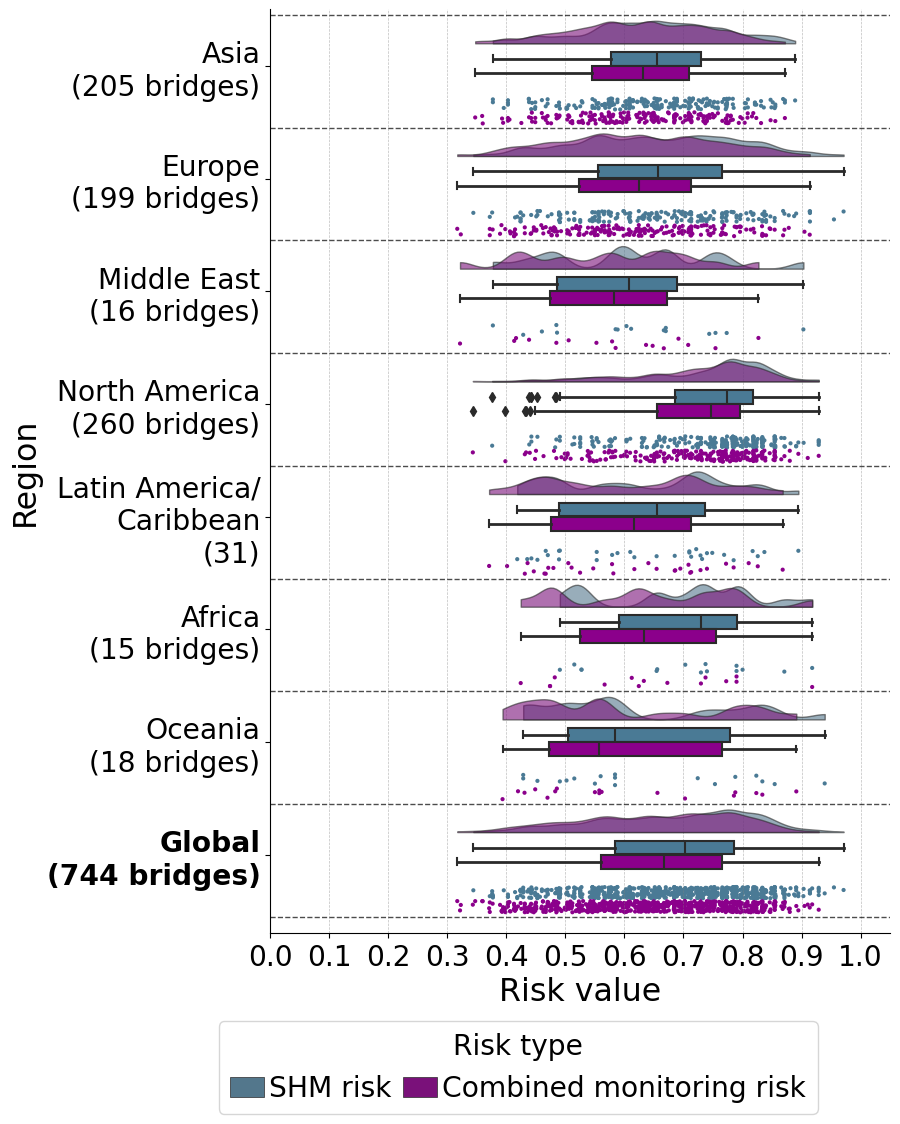

In [49]:

# Set font sizes for the figure
set_fonts_for_figure((8, 12)) 

# Create the rainplot
plt.figure(figsize=(8, 12))
ax = plt.gca()

# Create rainplot
pt.RainCloud(
    y="Risk Value", 
    x="Region_with_count", 
    hue="Risk Type",
    data=long_df, 
    palette=risk_colors, 
    bw=0.15,
    width_viol=0.4, 
    width_box =0.25,
    ax=ax, 
    orient="h", 
    move=0.4,
    alpha=0.6,
    box_medianprops={"zorder": 11},  # Ensure box median is on top
    dodge=True,  # Use dodge to separate the two risk types
)

# Customize the plot
ax.set_xlim(0, 1.05)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.xaxis.grid(True, which="both", color="grey", linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)
ax.set_ylim(7.7, -0.5)  # Adjust y-limits to accommodate all regions

# Add horizontal lines between regions
for i in range(-2, 8):
    ax.axhline(y=i + 1.55, color="black", linestyle="--", linewidth=1, alpha=0.7)


# Customize labels and ticks
ax.tick_params(axis="x")
ax.tick_params(axis="y")
plt.xlabel("Risk value")
plt.ylabel("Region")



# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ["SHM risk", "Combined monitoring risk"]
ax.legend(
    handles,
    new_labels,
    title="Risk type",
    bbox_to_anchor=(0.4, -0.08),
    loc="upper center",
    ncol=2,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)

# Make "Global" label bold
for label in ax.get_yticklabels():
    if "Global" in label.get_text():
        label.set_fontweight('bold')

# Remove spines for cleaner look
sns.despine(ax=ax)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig6a_rainplot_risk.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

## Fig.6b relative change on a map

### Read data

In [50]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig6b_map_relative_change.csv"),
)

### Pre-processing

In [51]:
# Get the mean risk for each region for SHM and combined monitoring
mean_risk_shm = bridges_gdf.groupby("Region")["Multi-hazard_risk_shm"].mean()
mean_risk_shm.loc["Global"] = bridges_gdf["Multi-hazard_risk_shm"].mean()

mean_risk_com = bridges_gdf.groupby("Region")["Multi-hazard_risk_com"].mean()
mean_risk_com.loc["Global"] = bridges_gdf["Multi-hazard_risk_com"].mean()

# Calculate the difference
risk_difference = mean_risk_com - mean_risk_shm

# Calculate the percentage change
risk_percentage_change = (risk_difference / mean_risk_shm) * 100
    
# Define the mapping dictionary
region_mapping = {
    "Eastern Asia": "Asia",
    "Central Asia": "Asia",
    "Southern Asia": "Asia",
    "South-Eastern Asia": "Asia",
    "Western Europe": "Europe",
    "Southern Europe": "Europe",
    "Northern Europe": "Europe",
    "Eastern Europe": "Europe",
    "Western Asia": "Middle East",
    "Northern America": "North America",
    "South America": "Latin America/Caribbean",
    "Central America": "Latin America/Caribbean",
    "Caribbean": "Latin America/Caribbean",
    "Northern Africa": "Africa",
    "Western Africa": "Africa",
    "Middle Africa": "Africa",
    "Eastern Africa": "Africa",
    "Southern Africa": "Africa",
    "Micronesia": "Oceania",
    "Polynesia": "Oceania",
    "Australia and New Zealand": "Oceania",
    "Melanesia": "Oceania",
}

# Add the region_lsb column
world_geometries["region_lsb"] = world_geometries["region"].apply(
    lambda x: region_mapping.get(x, "Other")
)

# Remove everything that has region_lsb == Other
world_geometries = world_geometries[world_geometries["region_lsb"] != "Other"]

# Change Afghanistan, Iran, and Pakistan as they are also classsified as
# Middle East in long-span brdgs db
world_geometries.loc[world_geometries["name"] == "Afghanistan", "region_lsb"] = (
    "Middle East"
)
world_geometries.loc[
    world_geometries["name"] == "Iran (Islamic Republic of)", "region_lsb"
] = "Middle East"
world_geometries.loc[world_geometries["name"] == "Pakistan", "region_lsb"] = (
    "Middle East"
)

# Create a separate gdf that contains only the regions
world_geometries_regions = world_geometries.dissolve(by="region_lsb")

world_geometries_regions = world_geometries_regions[["geometry"]]

# compute centroids for annotations
world_geometries_regions_projected = world_geometries_regions.to_crs(epsg=3035)
world_geometries_regions_projected["centroid"] = (
    world_geometries_regions_projected.geometry.centroid
)
world_geometries_regions["centroid"] = world_geometries_regions_projected[
    "centroid"
].to_crs(world_geometries_regions.crs)

# Assign percentage change to regions (disregard global for now)
world_geometries_regions.loc[:, "percentage_change"] = risk_percentage_change[:-1]

world_geometries_regions.rename(
    index={
        "Middle East": "Middle \nEast",
        "Latin America/Caribbean": "Latin America \nand Caribbean",
    },
    inplace=True,
)

regions_to_annotate = [
    "Africa",
    "Asia",
    "Europe",
    "Latin America \nand Caribbean",
    "Middle \nEast",
    "North America",
    "Oceania",
]

adjustments = {
    "Africa": (-10, -10),
    "Asia": (0, -15),
    "Europe": (-60, -28),
    "Latin America \nand Caribbean": (0, -45),
    "Middle \nEast": (0, -20),
    "North America": (-5, -20),
    "Oceania": (0, -13),
}


### Plot

Africa 8.850324031873065 -1.7652719051171548
Asia 94.29936858004788 19.58403326698066
Europe 5.502049297956418 39.99602945255896
Latin America 
and Caribbean -60.00774093182505 -49.33057870305618
Middle 
East 50.317561955143525 10.42261624932329
North America -100.21983585078391 37.00499106369395
Oceania 131.76961812268496 -32.37316589983823


/tmp/ipykernel_22730/533954192.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Global {risk_percentage_change[-1]:.2f}%",


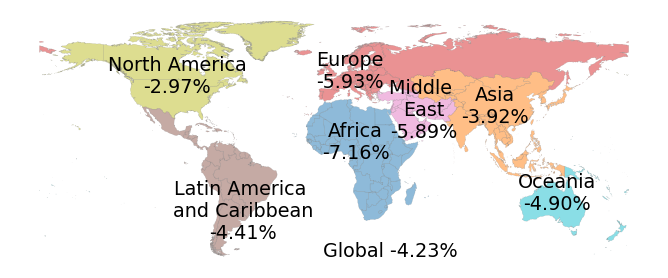

In [52]:


# Set font sizes for the figure
set_fonts_for_figure((7, 10)) 

# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(7, 10))

# create the plot
world_geometries.plot(
    column="region_lsb", ax=ax, edgecolor="grey", linewidth=0.2, alpha=0.5
)

# custom axis
# ax.set_xlim(-15, 35)
# ax.set_ylim(32, 72)
ax.axis("off")

# annotate regions
for region in regions_to_annotate:

    # get centroid
    centroid = world_geometries_regions.loc[
        world_geometries_regions.index == region, "centroid"
    ].values[0]
    x, y = centroid.coords[0]

    # get corrections
    x += adjustments[region][0]
    y += adjustments[region][1]

    print(region, x, y)

    # get rate and annotate
    rate = world_geometries_regions.loc[
        world_geometries_regions.index == region, "percentage_change"
    ].values[0]
    ax.annotate(
        f"{region}\n{rate:.2f}%",
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),
        ha="center",
        fontsize=plt.rcParams['font.size'] * 0.8,
        fontfamily="DejaVu Sans",
        color="black",
    )

# Add global
ax.annotate(
    f"Global {risk_percentage_change[-1]:.2f}%",
    (30, -60),
    textcoords="offset points",
    xytext=(5, 5),
    ha="center",
    fontsize=plt.rcParams['font.size'] * 0.8,
    fontfamily="DejaVu Sans",
    color="black",
)

# display the plot
plt.tight_layout()
plt.savefig(
    os.path.join(plots_path, "fig6b_map_relative_change.jpg"),
    dpi=600,
    bbox_inches="tight",
    # pad_inches=0,
)
plt.show()
plt.close()

# Fig.7 Change in Sentinel-1 availability

## Fig.7a Comparison before and after failure

### Read data

In [53]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig7a_sentinel_availability.csv"),
)

### Pre-processing

In [54]:
# Create mapping for 1 satellite availability classes
snt_1sc_category_mapping = {
    0: "No SNT\navailability",
    3: "12 days\n1 s/c",
    4: "12 days\n2 s/c", 

}

# Define the desired order for display (best to worst)
snt_1sc_labels = [
    "12 days\n2 s/c", 
    "12 days\n1 s/c",
    "No SNT\navailability"
]

snt_1sc_labels_new = [
    "12 days\n2 satellites", 
    "12 days\n1 satellite",
    "No SNT\navailability"
]


# Apply the mapping to create labeled categories
bridges_gdf["SNT_availability_1sc_labels"] = bridges_gdf["SNT_availability_1sc"].map(snt_1sc_category_mapping)

# Convert to ordered categorical to control the order in the plot
bridges_gdf["SNT_availability_1sc_labels"] = pd.Categorical(
    bridges_gdf["SNT_availability_1sc_labels"],
    categories=snt_1sc_labels,
    ordered=True
)

# Define colors for 1 satellite scenario
colors_1sc = [
    color_palette_SNT["12 days\n 2 s/c"],   # Best case  
    color_palette_SNT["12 days\n 1 s/c"],  # Medium case
    color_palette_SNT["No SNT \n availability"]  # Worst case
]

# Calculate proportions for the bar plot
proportions_1sc = bridges_gdf["SNT_availability_1sc_labels"].value_counts(normalize=True)
# Reorder to match the desired order
proportions_1sc = proportions_1sc.reindex(snt_1sc_labels)

### Plot

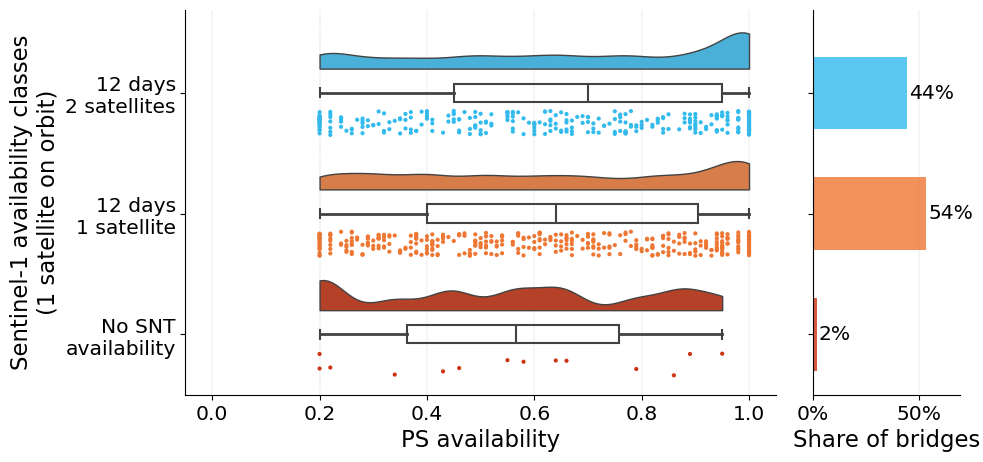

In [55]:


# Set font sizes for the figure
set_fonts_for_figure((10, 5))

# Create two subplots sharing y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True,
                        gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Left subplot: Rainplot showing PS availability distribution for each SNT class
pt.RainCloud(x="SNT_availability_1sc_labels", y="Monitoring_PS_availability_only",
                data=bridges_gdf, palette=colors_1sc, bw=0.15,
                width_viol=.6, ax=ax1, orient="h", move=0.25)

# Customize left subplot
ax1.set_xlabel("PS availability")
ax1.set_ylabel("Sentinel-1 availability classes\n(1 satellite on orbit)")
ax1.set_xlim(-.05, 1.05)

# Set y-tick labels
ax1.set_yticks(range(len(snt_1sc_labels)))
ax1.set_yticklabels(snt_1sc_labels_new)
ax1.tick_params(axis="x")

# Add grid for left subplot
ax1.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax1.set_axisbelow(True)

# Right subplot: Horizontal bar chart showing proportion of bridges in each category
bar_height = 0.6
for i, (label, prop) in enumerate(proportions_1sc.items()):
    ax2.barh(y=i, width=prop, height=bar_height,
            color=colors_1sc[i], alpha=0.8)
    # Add percentage labels at the end of bars
    ax2.text(prop + 0.01, i, f"{prop:.0%}",
            ha="left", va="center")

# Customize right subplot
ax2.set_xlabel("Share of bridges")
ax2.set_xlim(0, max(proportions_1sc) * 1.3)
ax2.tick_params(axis="x")

# Format x-axis as percentages
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))

# Add grid for bar chart
ax2.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax2.set_axisbelow(True)

# Remove spines
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Save the plot
plt.savefig(
    os.path.join(plots_path, "fig7a_sentinel_availability.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

## Fig.7b Change in Sentinel-1 availability on a map

### Read data

In [56]:
# Read data
bridges_gdf = pd.read_csv(
    os.path.join(source_data_folder, "fig7b_map_snt_availability_change.csv"),
)

### Pre-processing

In [57]:
# Convert WKT strings to geometry objects
bridges_gdf['geometry'] = bridges_gdf['geometry'].apply(wkt.loads)

# Create GeoDataFrame
bridges_gdf = gpd.GeoDataFrame(bridges_gdf, geometry='geometry')

# Set coordinate reference system if needed (e.g., WGS84)
bridges_gdf = bridges_gdf.set_crs('EPSG:4326')

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 4)
    & (bridges_gdf["SNT_availability_1sc"] == 3),
    "SNT_availability_change",
] = "Lost 1 s/c"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 1)
    & (bridges_gdf["SNT_availability_1sc"] == 3),
    "SNT_availability_change",
] = "Increased time"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 2)
    & (bridges_gdf["SNT_availability_1sc"] == 4),
    "SNT_availability_change",
] = "Increased time"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 3)
    & (bridges_gdf["SNT_availability_1sc"] == 3),
    "SNT_availability_change",
] = "No change"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 4)
    & (bridges_gdf["SNT_availability_1sc"] == 4),
    "SNT_availability_change",
] = "No change"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 3)
    & (bridges_gdf["SNT_availability_1sc"] == 0),
    "SNT_availability_change",
] = "Availability lost completely"

bridges_gdf.loc[
    (bridges_gdf["SNT_availability_2sc"] == 3)
    & (bridges_gdf["SNT_availability_1sc"] == 4),
    "SNT_availability_change",
] = "Increased s/c availability"

# Count how availability changed
snt_change_counted = bridges_gdf["SNT_availability_change"].value_counts()

# Define the mapping dictionary
snt_availability_change_mapping = {
    "Increased time": 1,
    "No change": 2,
    "Lost 1 s/c": 3,
    "Increased s/c availability": 4,
    "Availability lost completely": 5,
}

reverse_mapping = {v: k for k, v in snt_availability_change_mapping.items()}

# Create a new column with numerical values
bridges_gdf["SNT_availability_change_num"] = bridges_gdf[
    "SNT_availability_change"
].map(snt_availability_change_mapping)

# Define color dictionary for SNT_availability_change
color_dict_snt_change = {
    1: "#33BBEE",
    2: "#0077BB",
    3: "#EE7733",
    4: "#009988",
    5: "#CC3311",
}

# Define markers for each category
markers = {
    1: "o",  # Circle
    2: "s",  # Square
    3: "^",  # Triangle
    4: "P",  # Plus
    5: "D",  # Diamond
}

# Define bounds and tick labels for SNT_availability_change
bounds_snt_change = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
tick_labels_snt_change = [
    "Lost 1 satellite ({})".format(snt_change_counted["Lost 1 s/c"]),
    "Increased time ({})".format(snt_change_counted["Increased time"]),
    "No change ({})".format(snt_change_counted["No change"]),
    "Availability lost\ncompletely ({})".format(
        snt_change_counted["Availability lost completely"]
    ),
    "Covered by 2 satellites\ninstead of 1 ({})".format(
        snt_change_counted["Increased s/c availability"]
    ),
]
tick_locations_snt_change = [1, 2, 3, 4, 5]

# Plot map for SNT_availability_change
col_title = "SNT_availability_change_num"
plot_title = "SNT Availability Change"
color_dict = color_dict_snt_change
bounds = bounds_snt_change
tick_labels = tick_labels_snt_change
tick_locations = tick_locations_snt_change


### Plot

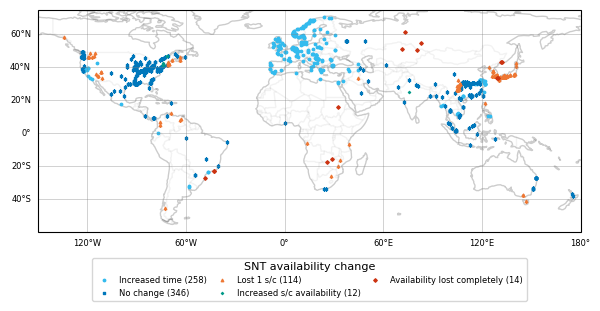

In [58]:
# Set font sizes for the figure
set_fonts_for_figure((7, 14))

# Create a map
fig, ax = plt.subplots(
    figsize=(7, 14), subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.set_global()
ax.coastlines(edgecolor="gray", alpha=0.2)
ax.add_feature(cfeature.BORDERS, edgecolor="gray", alpha=0.1)

# Define the colormap
cmap = mcolors.ListedColormap(list(color_dict.values()))

# Define the color boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot each category separately with different markers
for category, marker in markers.items():
    subset = bridges_gdf[bridges_gdf[col_title] == category]
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        label=f"{reverse_mapping[category]} ({snt_change_counted[reverse_mapping[category]]})",
        marker=marker,
        color=color_dict_snt_change[category],
        s=3,  # Adjust marker size as needed
        zorder=2,
    )

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5)
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}
gl.top_labels = False
gl.right_labels = False

# Add a legend instead of a colorbar
ax.legend(
    title="SNT availability change",
    title_fontsize=8,
    fontsize=6,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,  # Adjust the number of columns in the legend
    columnspacing=0.8,
)

ax.set_xlabel("Longitude", fontsize=8)
ax.set_ylabel("Latitude", fontsize=8)

ax.set_xlim([-150, 180])
ax.set_ylim([-60, 75])

# ax.set_title(plot_title, fontsize=20)

plt.savefig(
    os.path.join(plots_path, f"fig7b_map_{col_title}.jpg"),
    dpi=600,
    bbox_inches="tight",
)

plt.show()

plt.close()


# Supplement Figures

## Supplementary Fig.1 Distribution of PS availability depending on bridge type showing differences in distribution between span

### Read data

In [59]:
# Read data
bridges_gdf = pd.read_csv(
os.path.join(source_data_folder, "figSup1_ps_availability_by_segment_and_bridge_type.csv"),
)


### Pre-processing

In [60]:
column_name = "Bridge Type"
segments = [
    "PS_availability_edge",
    "PS_availability_intermediate", 
    "PS_availability_central"
]
segment_labels = ["Edge", "Intermediate", "Central"]

desired_order = ["Arch", "Cable-Stayed", "Cantilever", "Truss", "Suspension"]

# Create the classes for each segment (your existing code)
availability_labels = [
    "[0, 0.2]",
    "(0.2, 0.4]", 
    "(0.4, 0.6]",
    "(0.6, 0.8]",
    "(0.8, 1.0]",
]

for segment in segments:
    bridges_gdf[f"{segment}_classes"] = pd.cut(
        bridges_gdf[segment],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=availability_labels,
        right=True,
        include_lowest=True,
    )


### Plot

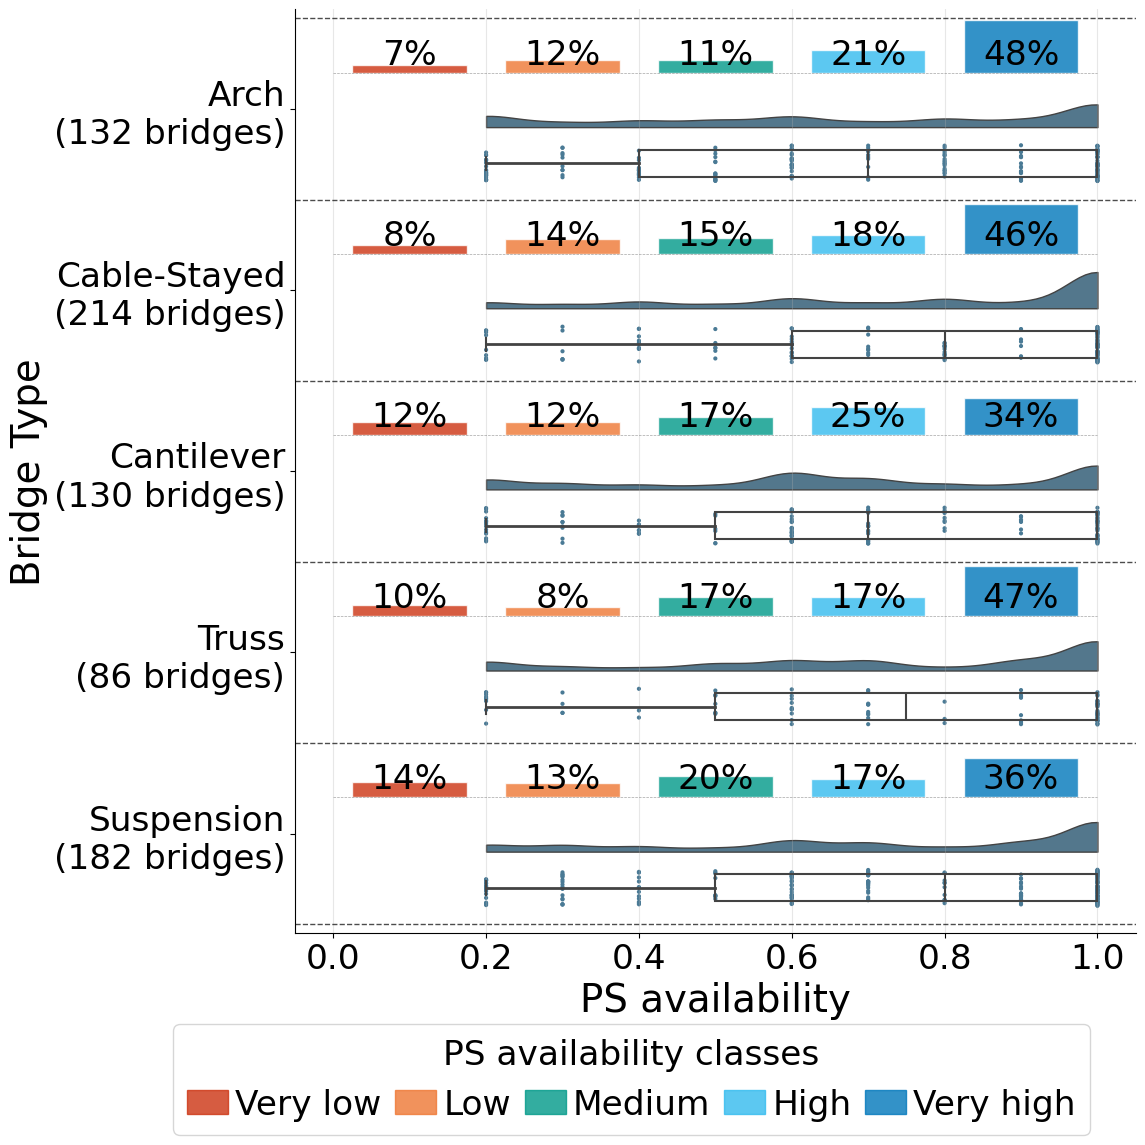

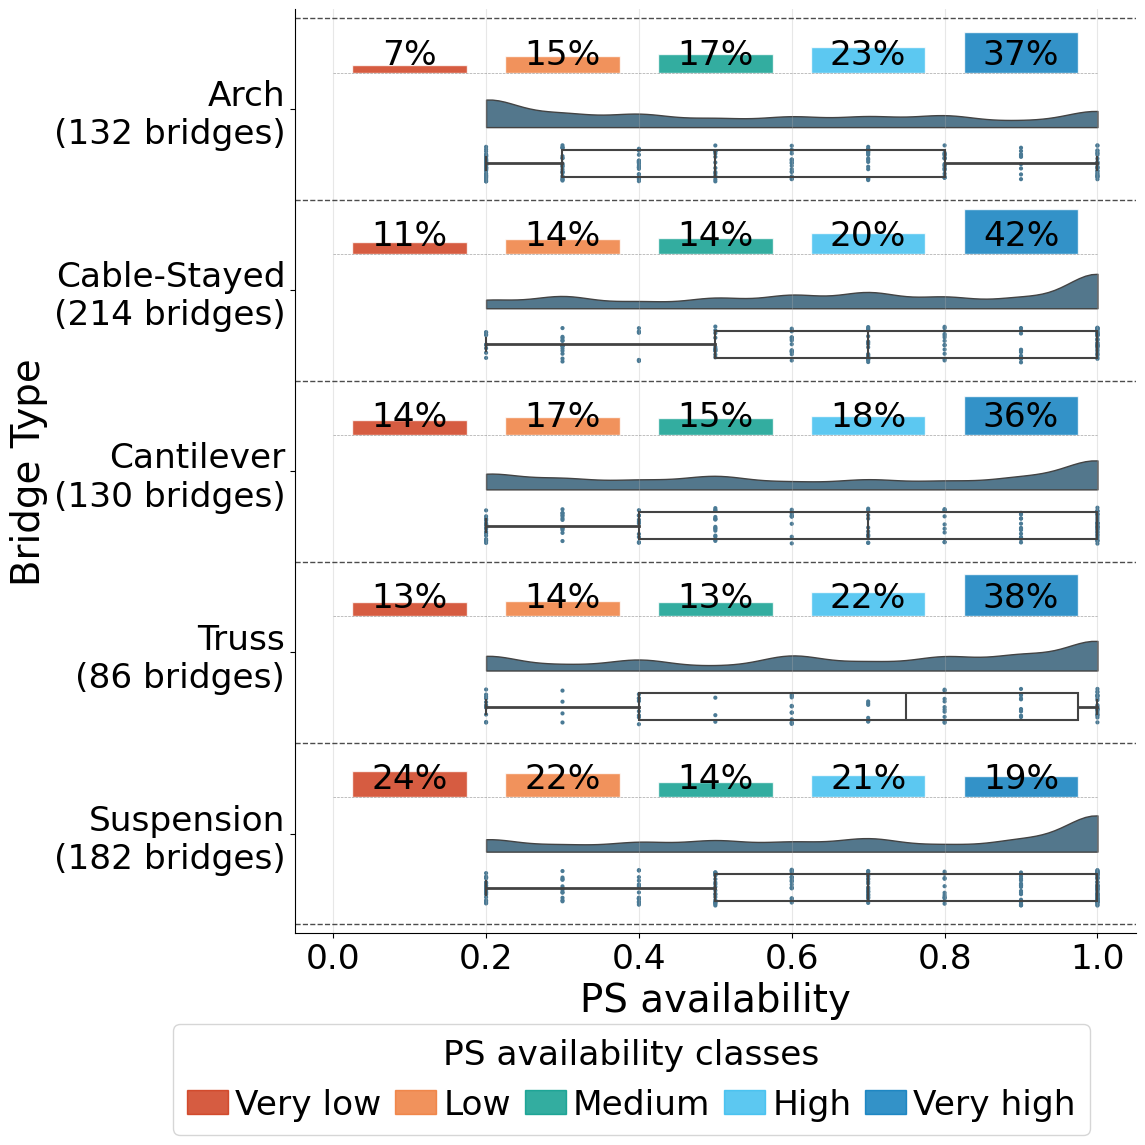

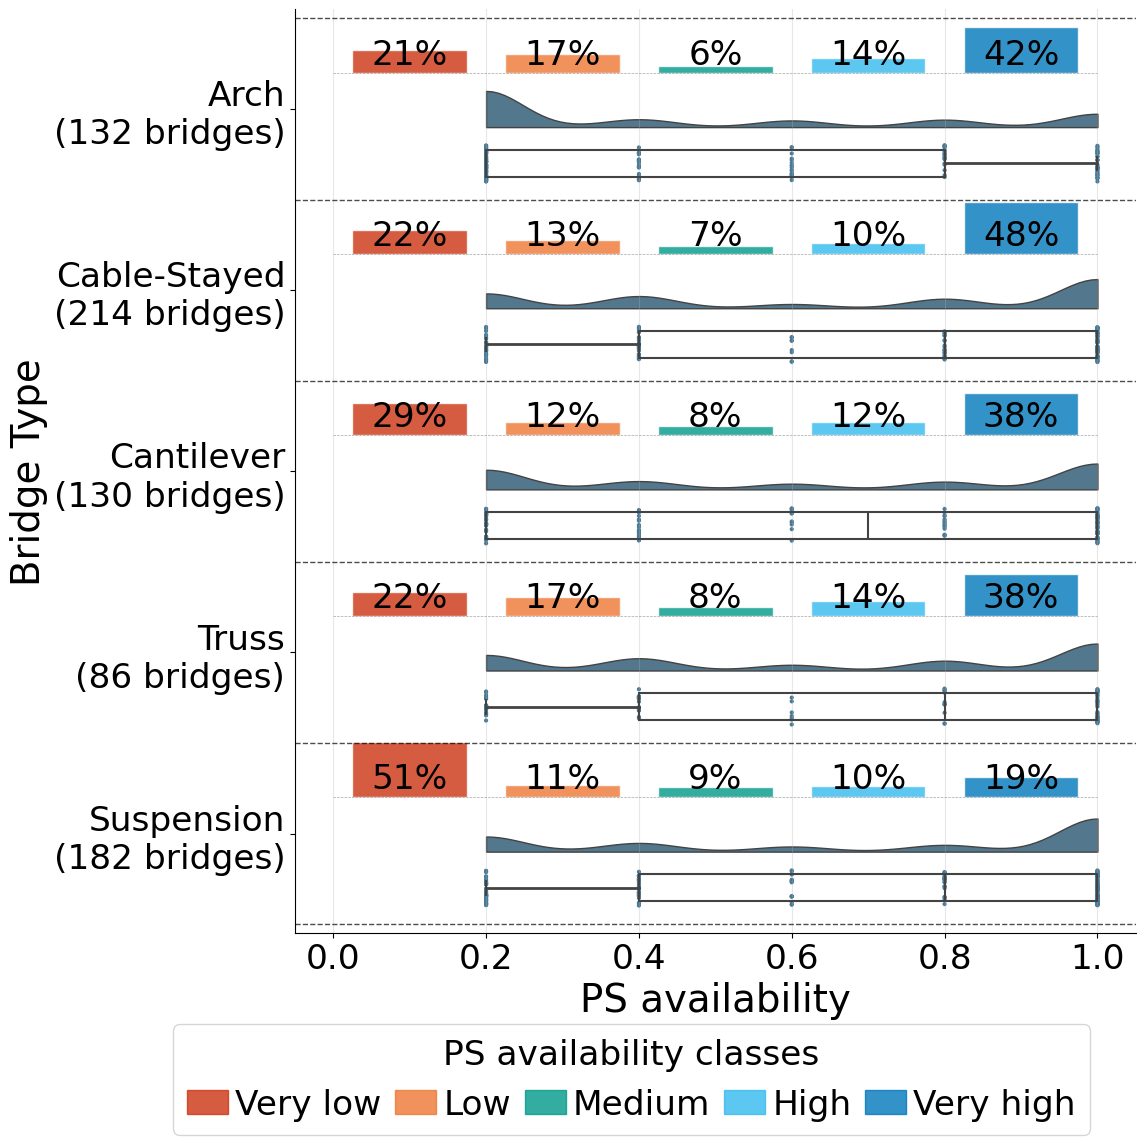

In [62]:

# Now create three separate plots
for i, (segment, segment_label) in enumerate(zip(segments, segment_labels)):
    # Create a copy of the dataframe for this segment
    temp_gdf = bridges_gdf.copy()
    
    # Temporarily rename the segment columns to what the function expects
    temp_gdf["Monitoring_PS_availability_only"] = temp_gdf[segment]
    temp_gdf["Monitoring_PS_availability_classes"] = temp_gdf[f"{segment}_classes"]
    
    # Create the plot for this segment
    plot_ps_availability_with_distribution(
        bridges_gdf=temp_gdf,
        column_name=column_name,
        desired_order=desired_order,
        custom_cmap=custom_cmap,
        plots_path=plots_path,
        figure_id=f"figSup1_ps_availability_{segment_label.lower()}"
    )

## Supplementary Fig.2 Map showing the location of all bridges from the database employed in this study

### Read data

In [63]:
# Read data
bridges_gdf = pd.read_csv(
os.path.join(source_data_folder, "figSup2_map_bridges_locations.csv"),
)

### Pre-processing

In [64]:

# Convert WKT strings to geometry objects
bridges_gdf['geometry'] = bridges_gdf['geometry'].apply(wkt.loads)

# Create GeoDataFrame
bridges_gdf = gpd.GeoDataFrame(bridges_gdf, geometry='geometry')

# Set coordinate reference system if needed (e.g., WGS84)
bridges_gdf = bridges_gdf.set_crs('EPSG:4326')


# Define the mapping dictionary
region_mapping = {
    "Eastern Asia": "Asia",
    "Central Asia": "Asia",
    "Southern Asia": "Asia",
    "South-Eastern Asia": "Asia",
    "Western Europe": "Europe",
    "Southern Europe": "Europe",
    "Northern Europe": "Europe",
    "Eastern Europe": "Europe",
    "Western Asia": "Middle East",
    "Northern America": "North America",
    "South America": "Latin America/Caribbean",
    "Central America": "Latin America/Caribbean",
    "Caribbean": "Latin America/Caribbean",
    "Northern Africa": "Africa",
    "Western Africa": "Africa",
    "Middle Africa": "Africa",
    "Eastern Africa": "Africa",
    "Southern Africa": "Africa",
    "Micronesia": "Oceania",
    "Polynesia": "Oceania",
    "Australia and New Zealand": "Oceania",
    "Melanesia": "Oceania",
}

# Add the region_lsb column
world_geometries["region_lsb"] = world_geometries["region"].apply(
    lambda x: region_mapping.get(x, "Other")
)

# Remove everything that has region_lsb == Other
world_geometries = world_geometries[world_geometries["region_lsb"] != "Other"]

# Change Afghanistan, Iran, and Pakistan as they are also classsified as
# Middle East in long-span brdgs db
world_geometries.loc[world_geometries["name"] == "Afghanistan", "region_lsb"] = (
    "Middle East"
)
world_geometries.loc[
    world_geometries["name"] == "Iran (Islamic Republic of)", "region_lsb"
] = "Middle East"
world_geometries.loc[world_geometries["name"] == "Pakistan", "region_lsb"] = (
    "Middle East"
)


### Plot

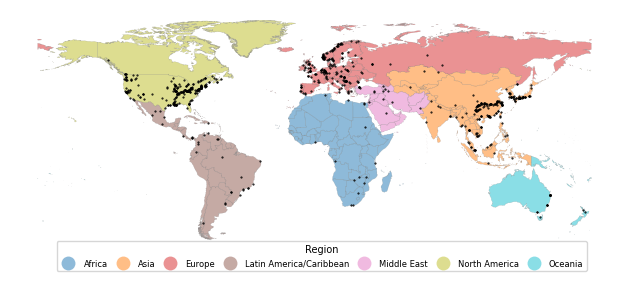

In [65]:
# Set font sizes for the figure
set_fonts_for_figure((7, 14))

# Plot map with bridge locations

# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(7, 14))

# create the plot
world_geometries.plot(
    column="region_lsb",
    ax=ax,
    edgecolor="grey",
    linewidth=0.2,
    alpha=0.5,
    legend=True,
    legend_kwds={
        "title": "Region",
        "fontsize": 6,
        "title_fontsize": 7,
        "bbox_to_anchor": (0.07, -0.1),
        "loc": "lower left",
        "ncol": 7,
        "columnspacing": 0.8,
    },
)
bridges_gdf.plot(
    ax=ax,
    facecolor="black",
    edgecolor="black",
    linewidth=1,
    markersize=1,
    marker=".",
)

# custom axis
# ax.set_xlim(-15, 35)
# ax.set_ylim(32, 72)
ax.axis("off")

# display the plot
plt.tight_layout()
plt.savefig(
    os.path.join(plots_path, "figSup2_map_bridges_locations.jpg"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.1,
)
plt.show()
plt.close()

## Supplementary Fig.5 Monitoring factor sensitivity analysis

#### Read data

In [ ]:
# Read data
bridges_gdf = pd.read_csv(
os.path.join(source_data_folder, "figSup5_monitoring_factor_sensitivity.csv"),
)

### Fig.5a Risk rainplots comparison

#### Pre-processing

In [67]:
# Reshape the data for plotting
scenario_columns = ['1.15', '1.25', '1.35', '1.45', '1.55']

# Melt the dataframe to long format
bridges_melted = bridges_gdf.melt(
    id_vars=['ID', 'Region'], 
    value_vars=scenario_columns,
    var_name='Scenario',
    value_name='Risk_Value'
)

# Create risk categories for the melted data
bridges_melted["Risk_Category"] = pd.cut(
    bridges_melted["Risk_Value"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
    labels=["Very Low", "Low", "Medium", "High", "Very High"],
    right=True,
    include_lowest=True,
)


# Define colors for scenarios (different shades of blue)
scenario_colors = [
    "#08306b",  # Very dark blue
    "#2171b5",  # Dark blue
    "#4292c6",  # Medium blue
    "#6baed6",  # Light blue
    "#9ecae1",  # Very light blue
]

# Define colors for risk categories (matching your previous style)
risk_category_colors = [
    "#CC3311",  # Very High (red)
    "#EE7733",  # High (orange)
    "#009988",  # Medium (green)
    "#33BBEE",  # Low (light blue)
    "#0077BB",  # Very Low (blue)
][::-1]

#### Plot

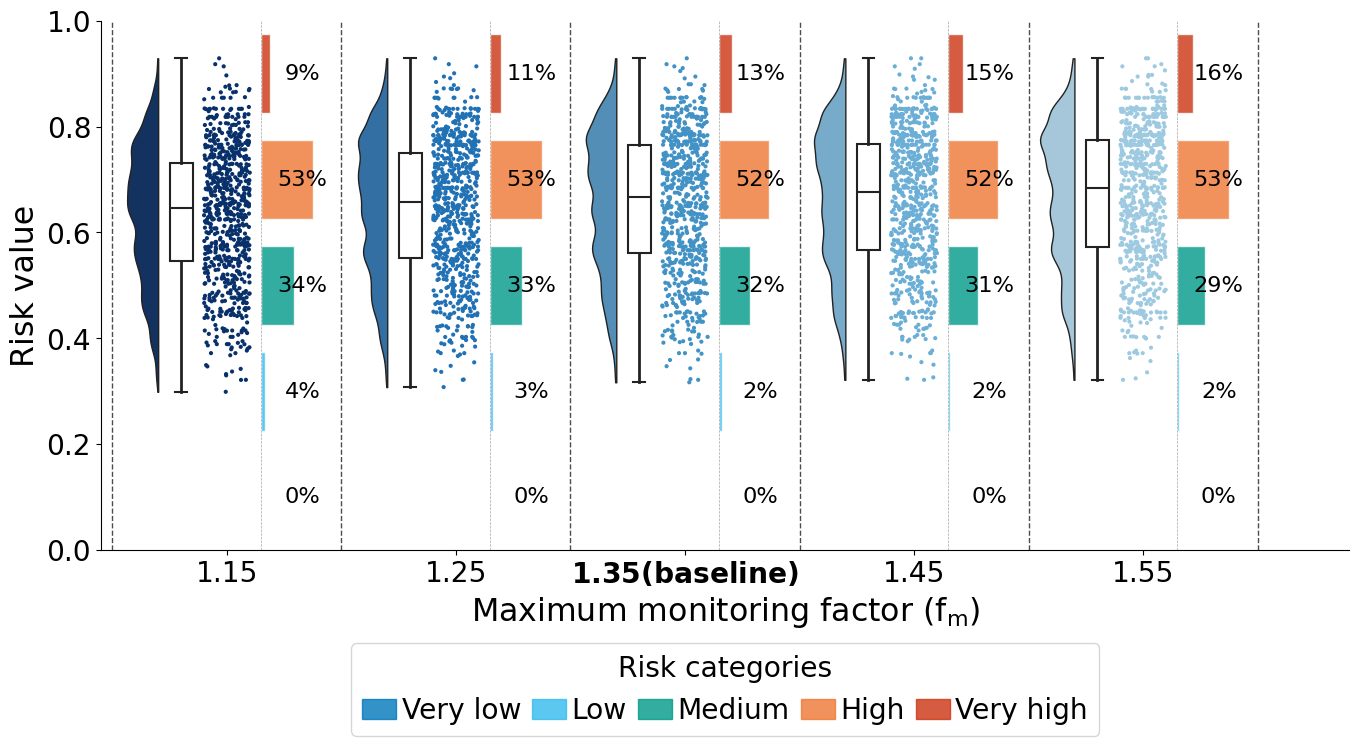

In [68]:

# Set font sizes for the figure
set_fonts_for_figure((12, 8))  # Uncomment if you have this function

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Create raincloud plot (vertical orientation)
pt.RainCloud(
    x="Scenario",
    y="Risk_Value", 
    data=bridges_melted,
    palette=scenario_colors,
    bw=0.15,
    width_viol=0.3,
    width_box=0.1,
    ax=ax,
    orient="v",
    move=0.2,
    offset=0.1,
)

# Now overlay histogram bars for each scenario
risk_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9]
bar_width = 0.15
bar_height_scale = 0.42  # Maximum height scaling for histogram bars

for i, scenario in enumerate(scenario_columns):
    scenario_data = bridges_melted[bridges_melted["Scenario"] == scenario]
    
    if len(scenario_data) > 0:
        # Calculate proportions for this scenario
        proportions = scenario_data["Risk_Category"].value_counts(normalize=True)
        proportions = proportions.reindex(risk_labels, fill_value=0)
        
        # X position - bottom level where all bars start
        x_bottom = i + 0.35  # Right edge of all bars for this scenario
        
        # Create histogram bars to the right of the raincloud for this scenario
        for j, (label, prop) in enumerate(proportions.items()):
            if prop > 0:
                # Calculate actual bar width
                bar_actual_width = bar_height_scale * prop
                
                # Position bar so its left starts at x_bottom and extends rightward
                bar_x_position = x_bottom + bar_actual_width / 2
                
                # Create bar
                ax.bar(
                    x=bar_x_position,
                    height=bar_width,
                    width=bar_actual_width,
                    bottom=bin_centers[j] - bar_width / 2,
                    color=risk_category_colors[j],
                    alpha=0.8,
                    edgecolor="white",
                    linewidth=1,
                )
                
                # Add percentage label 
                ax.text(
                    x_bottom + 0.18,
                    bin_centers[j],
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*0.8,
                    color="black",
                    # rotation=90
                )
            else:
                # Add percentage label even for 0%
                ax.text(
                    x_bottom + 0.18,
                    bin_centers[j],
                    f"{prop:.0%}",
                    ha="center",
                    va="center",
                    fontsize=plt.rcParams['font.size']*0.8,
                    color="black",
                    # rotation=90
                )

# Customize the plot
ax.set_ylim(0, 1)
ax.set_xlim(-0.35, len(scenario_columns) + 0.1)  # Extended to accommodate bars
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
ax.set_xlabel("Maximum monitoring factor ($f_m$)")
ax.set_ylabel("Risk value")

# Update x-tick labels
x_labels = []
for scenario in scenario_columns:
    if scenario == "1.35":
        x_labels.append(f"$\\mathbf{{{scenario} (baseline)}}$")  # Bold for 1.35
    else:
        x_labels.append(f"{scenario}")
ax.set_xticks([i + 0.2 for i in range(len(scenario_columns))])
ax.set_xticklabels(x_labels)


# Add grid
# ax.yaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
ax.set_axisbelow(True)

# Add vertical lines for bar plots
for i in range(-1, len(scenario_columns)):
    ax.vlines(
        x=i + 0.35,
        ymin=0,
        ymax=1,
        color="grey",
        linestyle="--",
        linewidth=0.5,
        alpha=0.7,
    )

# Add vertical lines between scenarios
for i in range(-2, len(scenario_columns)):
    ax.axvline(x=i + .7, color="black", linestyle="--", linewidth=1, alpha=0.7)

# Add legend below the plot
legend_elements = [
    plt.Rectangle(
        (0, 0), 1, 1, color=risk_category_colors[i], alpha=0.8, label=risk_labels[i].capitalize()
    )
    for i in range(len(risk_labels))
]
ax.legend(
    handles=legend_elements,
    title="Risk categories",
    bbox_to_anchor=(0.5, -0.15),
    loc="upper center",
    ncol=5,
    handlelength=1.2,
    columnspacing=0.4,
    handletextpad=0.2,
)

# Clean styling
sns.despine(ax=ax)

plt.tight_layout()

# Save the plot
plt.savefig(
    os.path.join(plots_path, "figSup5a_monitoring_factor_sensitvity.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

# # Optional: Print some summary statistics
# print("Summary statistics by scenario:")
# summary_stats = bridges_melted.groupby('Scenario')['Risk_Value'].agg(['count', 'mean', 'std', 'min', 'max'])
# print(summary_stats)

# print("\nRisk category distribution by scenario:")
# risk_distribution = bridges_melted.groupby(['Scenario', 'Risk_Category']).size().unstack(fill_value=0)
# risk_distribution_pct = risk_distribution.div(risk_distribution.sum(axis=1), axis=0) * 100
# print(risk_distribution_pct.round(1))

### Fig.5b Direct comparison of risk values

#### Pre-processing

In [69]:
# Function to determine category based on value
def get_category(value):
    if value <= 0.2:
        return "Very Low"
    elif value <= 0.4:
        return "Low"
    elif value <= 0.6:
        return "Medium"
    elif value <= 0.8:
        return "High"
    else:
        return "Very High"

# Prepare data for plotting
scenario_columns = ['1.15', '1.25', '1.35', '1.45', '1.55']
baseline_scenario = '1.35'
comparison_scenarios = [s for s in scenario_columns if s != baseline_scenario]

# Define colors for each scenario (different shades of blue)
colors = {
    '1.15': '#08306b',  # Very dark blue
    '1.25': '#2171b5',  # Medium blue  
    '1.45': '#6baed6',  # Light blue
    '1.55': '#9ecae1'   # Very light blue
}


#### Plot

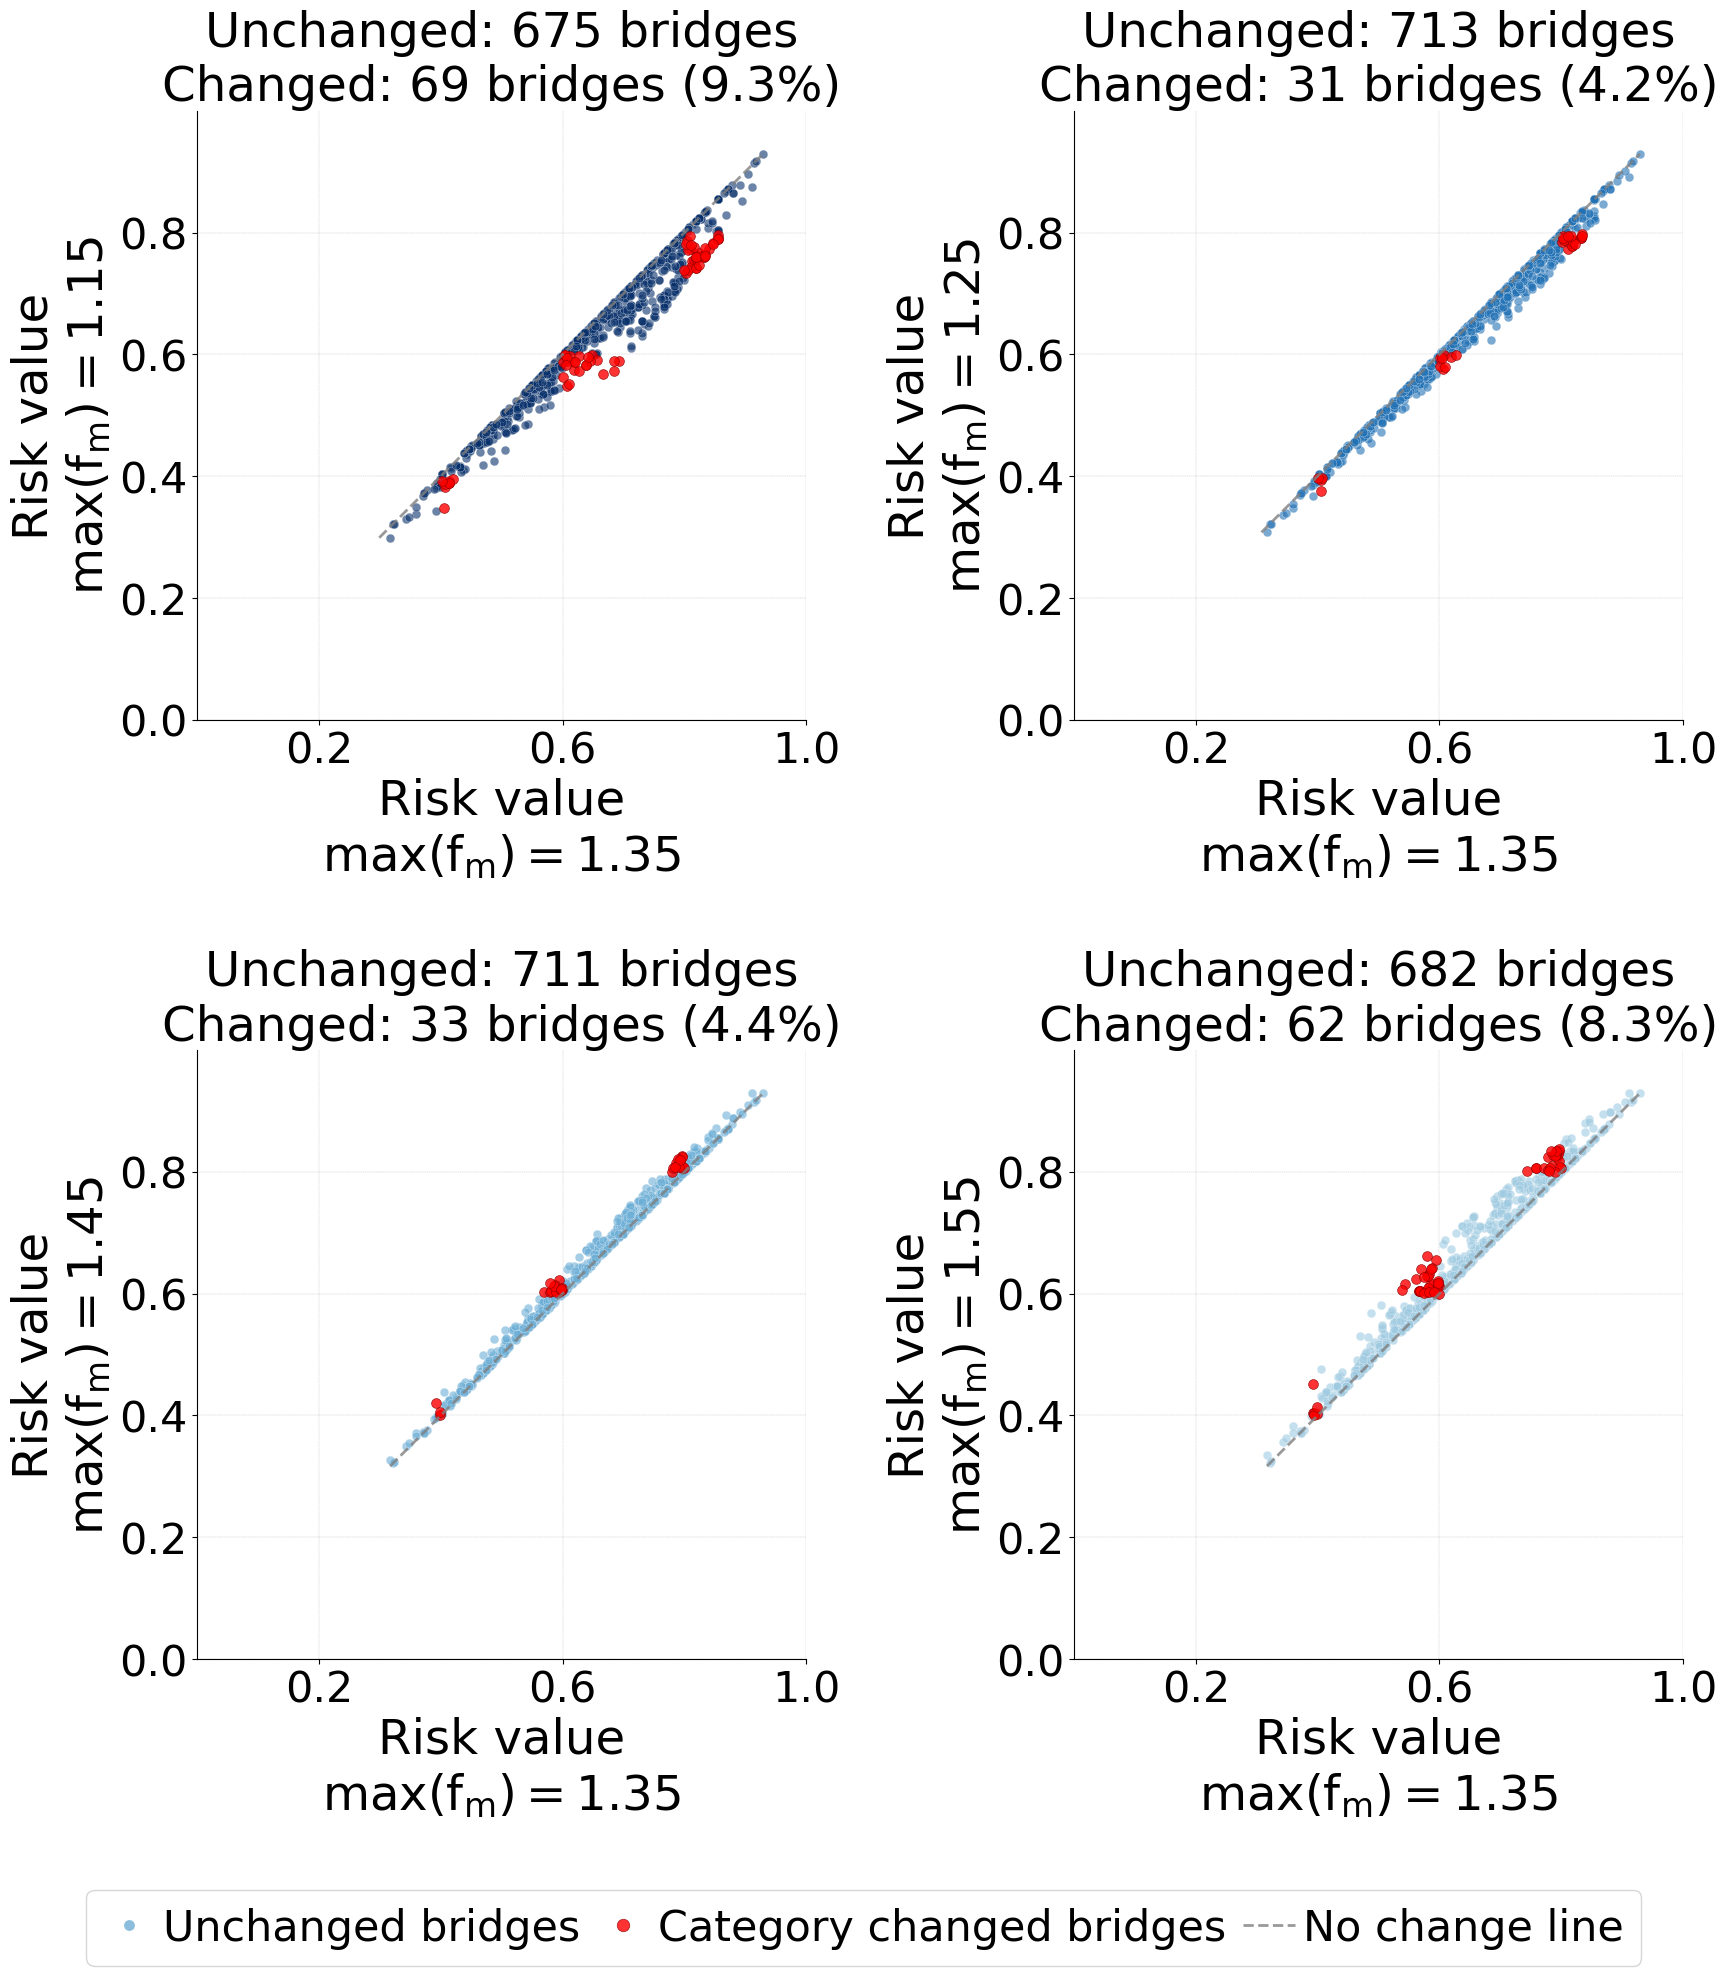

In [70]:
# Set font sizes for the figure
set_fonts_for_figure((16, 14))

# Create the plot with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 20))  # Increased height for legend space
axes = axes.flatten()

# Store legend elements (will be created from first subplot)
legend_elements = []

# Plot each scenario vs baseline
for i, scenario in enumerate(comparison_scenarios):
    ax = axes[i]
    
    # Determine categories for baseline and current scenario
    baseline_categories = bridges_gdf[baseline_scenario].apply(get_category)
    scenario_categories = bridges_gdf[scenario].apply(get_category)
    
    # Identify bridges that changed categories
    category_changed = baseline_categories != scenario_categories
    
    # Split data into changed and unchanged
    unchanged_mask = ~category_changed
    changed_mask = category_changed
    
    # Plot unchanged bridges in scenario color
    unchanged_scatter = None
    if unchanged_mask.any():
        unchanged_scatter = ax.scatter(
            bridges_gdf.loc[unchanged_mask, baseline_scenario], 
            bridges_gdf.loc[unchanged_mask, scenario],
            c=colors[scenario],
            alpha=0.6,
            s=40,
            edgecolors='white',
            linewidth=0.3
        )
    
    # Plot changed bridges in red
    changed_scatter = None
    if changed_mask.any():
        changed_scatter = ax.scatter(
            bridges_gdf.loc[changed_mask, baseline_scenario], 
            bridges_gdf.loc[changed_mask, scenario],
            c='red',
            alpha=0.8,
            s=50,  # Slightly larger for visibility
            edgecolors='darkred',
            linewidth=0.5,
            marker='o'
        )
    
    # Add diagonal line (y=x) to show where values would be equal
    min_val = min(bridges_gdf[baseline_scenario].min(), bridges_gdf[scenario].min())
    max_val = max(bridges_gdf[baseline_scenario].max(), bridges_gdf[scenario].max())
    diagonal_line = ax.plot([min_val, max_val], [min_val, max_val], 'gray', linestyle='--', alpha=0.8, linewidth=2)[0]
    
    # Create legend elements from first subplot
    if i == 0:
        
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#4292c6', markersize=8, 
                    markeredgecolor='white', markeredgewidth=0.3, alpha=0.6, label='Unchanged bridges'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=9, 
                    markeredgecolor='darkred', markeredgewidth=0.5, alpha=0.8, label='Category changed bridges'),
            Line2D([0], [0], color='gray', linestyle='--', alpha=0.8, linewidth=2, label='No change line')
        ]
    
    # Customize subplot
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    ax.set_xlabel(f'Risk value\n$max(f_m)=${baseline_scenario}')
    ax.set_ylabel(f'Risk value\n$max(f_m)=${scenario}')
    
    # Add grid
    ax.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
    ax.set_axisbelow(True)
    
    # Make axes equal for better comparison
    ax.set_aspect('equal', adjustable='box')
    
    # Set x and y limits to be 0-1 
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Set tick labels every 0.2 and add grid
    ax.set_xticks([0.2, 0.6, 1.0])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()])
    ax.set_yticklabels([f'{y:.1f}' for y in ax.get_yticks()])
    ax.xaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
    ax.yaxis.grid(True, color="grey", linestyle="--", linewidth=0.3, alpha=0.5)
    
    
    # Clean styling
    sns.despine(ax=ax)

    # Add counts and category change percentage
    change_percent = (changed_mask.sum() / len(bridges_gdf)) * 100
    title_text = f'Unchanged: {unchanged_mask.sum()} bridges\nChanged: {changed_mask.sum()} bridges ({change_percent:.1f}%)'
    ax.set_title(title_text)

# Add single legend below all subplots
fig.legend(handles=legend_elements, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.02),
        ncol=3,
        handlelength=1.2,
        columnspacing=0.4,
        handletextpad=0.2,)

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make room for legend at bottom

# Save the plot
plt.savefig(
    os.path.join(plots_path, "figSup5b_risk_values_comparison.jpg"),
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

# # Print detailed analysis
# print("=== CATEGORY CHANGE ANALYSIS ===")
# print(f"Baseline scenario: {baseline_scenario}")

# # Category boundaries for reference
# print("\nCategory boundaries:")
# print("Very Low: 0.0 - 0.2")
# print("Low: 0.2 - 0.4") 
# print("Medium: 0.4 - 0.6")
# print("High: 0.6 - 0.8")
# print("Very High: 0.8 - 1.0")

# for scenario in comparison_scenarios:
#     print(f"\n=== SCENARIO {scenario} vs BASELINE ===")
    
#     # Determine categories
#     baseline_categories = bridges_gdf[baseline_scenario].apply(get_category)
#     scenario_categories = bridges_gdf[scenario].apply(get_category)
    
#     # Find category changes
#     category_changed = baseline_categories != scenario_categories
    
#     print(f"Total bridges with category changes: {category_changed.sum()} ({category_changed.sum()/len(bridges_gdf)*100:.1f}%)")
    
#     if category_changed.any():
#         # Analyze the types of changes
#         changes_df = pd.DataFrame({
#             'baseline_category': baseline_categories[category_changed],
#             'scenario_category': scenario_categories[category_changed],
#             'baseline_value': bridges_gdf.loc[category_changed, baseline_scenario],
#             'scenario_value': bridges_gdf.loc[category_changed, scenario]
#         })
        
#         print("\nTypes of category changes:")
#         change_summary = changes_df.groupby(['baseline_category', 'scenario_category']).size()
#         for (baseline_cat, scenario_cat), count in change_summary.items():
#             direction = "↑" if scenario_cat > baseline_cat else "↓"
#             print(f"  {baseline_cat} → {scenario_cat}: {count} bridges {direction}")
    
#     # Statistical summary
#     correlation = bridges_gdf[baseline_scenario].corr(bridges_gdf[scenario])
#     print(f"\nCorrelation with baseline: {correlation:.3f}")
#     print(f"Mean difference from baseline: {(bridges_gdf[scenario] - bridges_gdf[baseline_scenario]).mean():.6f}")

# # Summary table of all category changes
# print(f"\n=== SUMMARY OF ALL CATEGORY CHANGES ===")
# for scenario in comparison_scenarios:
#     baseline_categories = bridges_gdf[baseline_scenario].apply(get_category)
#     scenario_categories = bridges_gdf[scenario].apply(get_category)
#     category_changed = baseline_categories != scenario_categories
#     change_count = category_changed.sum()
#     change_percent = (change_count / len(bridges_gdf)) * 100
#     print(f"Scenario {scenario}: {change_count} bridges ({change_percent:.1f}%) changed categories")